In [1]:
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from chronos import Chronos2Pipeline

import optuna

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.ticker as ticker
import seaborn as sns
import os

from SalesDataLoader import *

/Users/luisgrewe/Documents/StockSalesPrediction/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_loader = SalesDataLoader(train_path='data/df_stock_sales_train.xlsx', test_path='data/df_stock_sales_test.xlsx', 
                 date_col='week', target_col='sales', 
                 id_cols=['store_number', 'product_number'])
df = data_loader.load_raw_data()

df_train = df["train"]
df_test = df["test"]

In [3]:
folders = ['images', 'results']

for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f"Created folder: {folder}")
    else:
        print(f"Folder already exists: {folder}")

Folder already exists: images
Folder already exists: results


## Data Quality

In [4]:
date_distribution = df_train['week'].value_counts().sort_index()
print(f"Minimum Rows in one week: {date_distribution.min()}")
print(f"Maximum Rows in one week: {date_distribution.max()}")

Minimum Rows in one week: 599
Maximum Rows in one week: 599


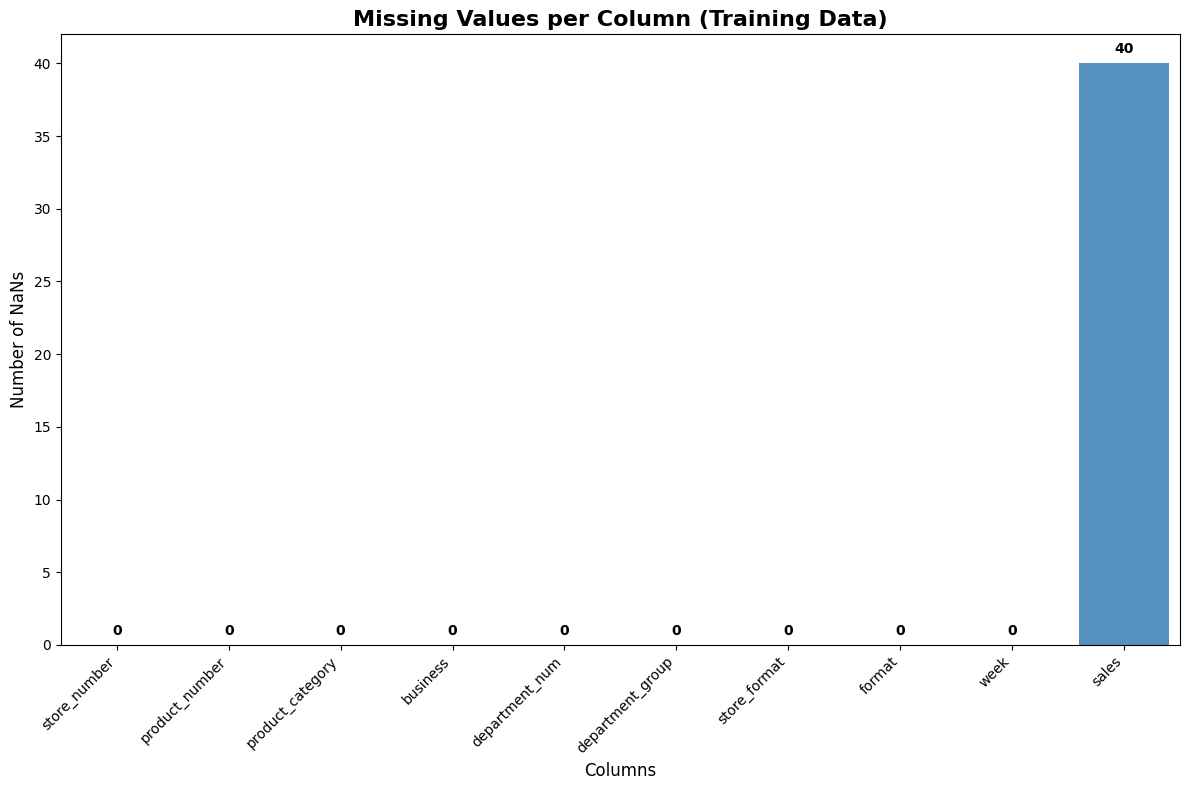

In [5]:
nan_counts = df_train.isna().sum()

plt.figure(figsize=(12, 8))
sns.barplot(x=nan_counts.index, y=nan_counts.values, color="#4293D0")

plt.title("Missing Values per Column (Training Data)", fontsize=16, fontweight='bold')
plt.ylabel("Number of NaNs", fontsize=12)
plt.xlabel("Columns", fontsize=12)
plt.xticks(rotation=45, ha='right')

for i, val in enumerate(nan_counts.values):
    plt.text(i, val + 0.5, str(val), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('images/missing_values.png', dpi=300)
plt.show()

## Preprocessing

In [6]:
## Exploratory Data Analysis

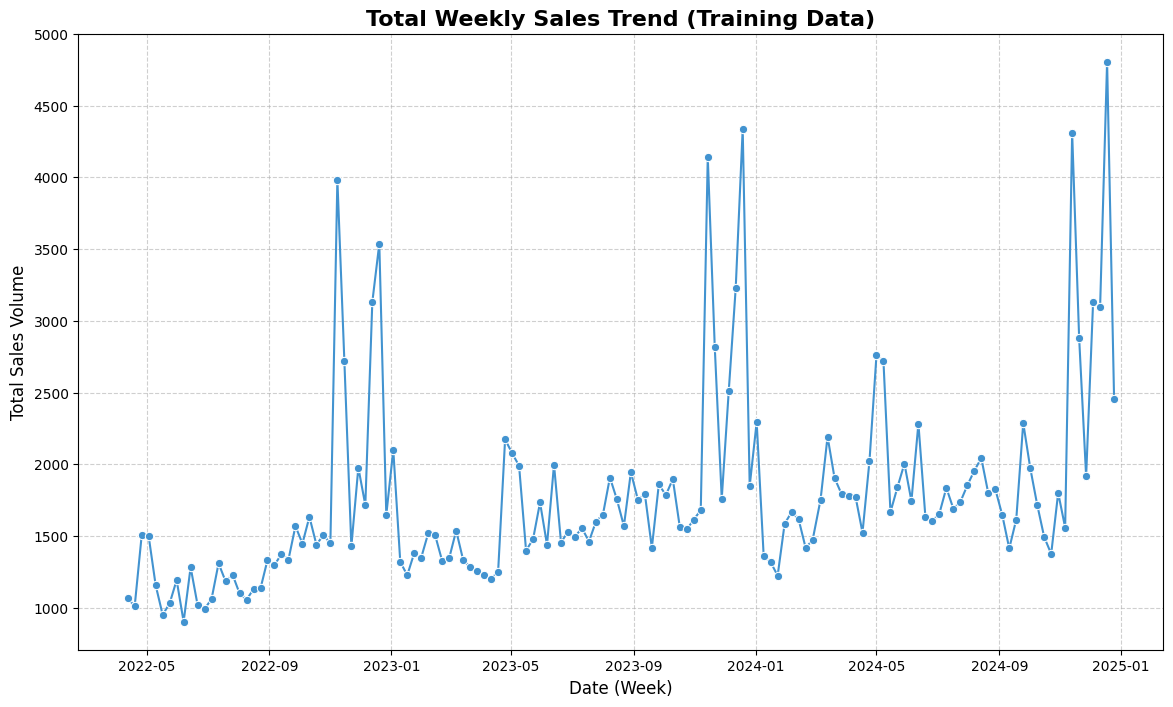

In [7]:
plt.figure(figsize=(14, 8))
weekly_sales = df_train.groupby('week')['sales'].sum().reset_index()
sns.lineplot(data=weekly_sales, x='week', y='sales', marker='o', color="#4293D0")
plt.title('Total Weekly Sales Trend (Training Data)', fontsize=16, fontweight='bold')
plt.xlabel('Date (Week)', fontsize=12)
plt.ylabel('Total Sales Volume', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('images/time_series.png', dpi=300)
plt.show()

product_number (297 values): [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)] ... [np.int64(292), np.int64(293), np.int64(294), np.int64(295), np.int64(296)]
product_category (111 values): [np.int64(20318), np.int64(20319), np.int64(30103), np.int64(30104), np.int64(40209), np.int64(40214), np.int64(40215), np.int64(40217), np.int64(50910), np.int64(90214)] ... [np.int64(540101), np.int64(540301), np.int64(580003), np.int64(580007), np.int64(590001)]
business (47 values): [np.int64(203), np.int64(301), np.int64(402), np.int64(509), np.int64(902), np.int64(905), np.int64(1404), np.int64(1405), np.int64(1406), np.int64(1706)] ... [np.int64(5400), np.int64(5401), np.int64(5403), np.int64(5800), np.int64(5900)]
department_num (26 values): [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(9), np.int64(14), np.int64(17), np.int64(20), np.int64(23), np.int64(24)] ... [np.int64(47), np.int64(53), np.i

/var/folders/f2/2y22t7gx2z5gdwk3d89ytmy00000gn/T/ipykernel_52470/30430972.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


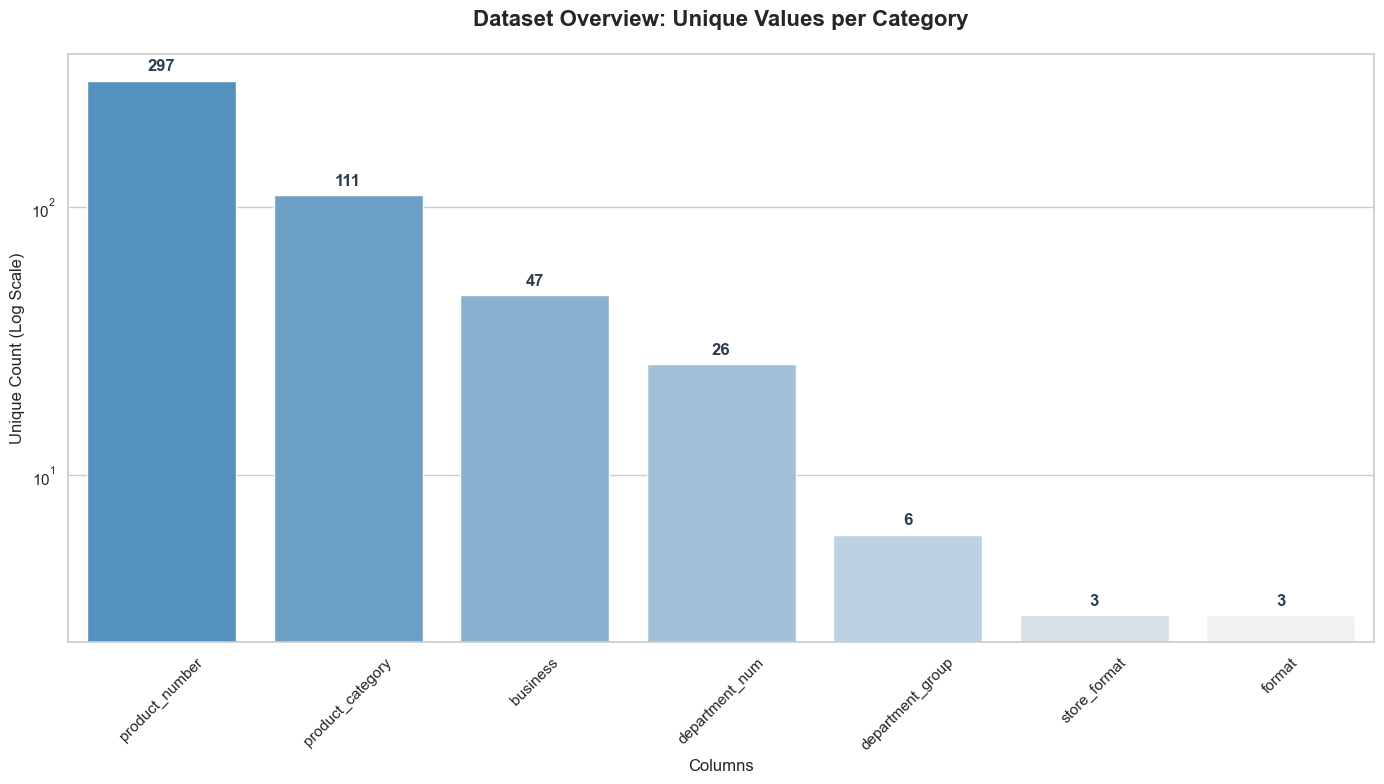

In [8]:
def display_dataset_summary(df):
    # Define the columns of interest
    cols = [
        'product_number', 'product_category', 'business',
        'department_num', 'department_group', 'store_format', 'format'
    ]

    # Calculate unique counts and retrieve actual values
    summary_data = []
    for col in cols:
        unique_vals = sorted(df[col].unique())
        num_unique = len(unique_vals)
        summary_data.append({'Dimension': col, 'Unique Count': num_unique})

        # Print actual values (truncated if there are more than 20)
        if num_unique <= 20:
            print(f"{col} ({num_unique} values): {unique_vals}")
        else:
            print(f"{col} ({num_unique} values): {unique_vals[:10]} ... {unique_vals[-5:]}")

    # Handle the 'week' column separately for the timeline
    if 'week' in df.columns:
        print(f"\nTimeline (week):")
        print(f"  Min Date: {df['week'].min()}")
        print(f"  Max Date: {df['week'].max()}")

    # Prepare the data for plotting
    summary_df = pd.DataFrame(summary_data).sort_values('Unique Count', ascending=False)

    plt.figure(figsize=(14, 8))
    sns.set_theme(style="whitegrid")

    # Create a gradient palette based on your specific blue tone (#4293D0)
    custom_palette = sns.light_palette("#4293D0", n_colors=len(summary_df), reverse=True)

    # Create the barplot using the custom blue palette
    ax = sns.barplot(
        x='Dimension',
        y='Unique Count',
        data=summary_df,
        palette=custom_palette
    )

    # Apply log scale for the y-axis (useful for comparing small vs large counts)
    plt.yscale('log')

    # Add data labels on top of the bars
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 10),
                    textcoords='offset points',
                    fontsize=12, fontweight='bold', color='#2c3e50')

    # Formatting the chart
    plt.title('Dataset Overview: Unique Values per Category', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Unique Count (Log Scale)', fontsize=12)
    plt.xlabel('Columns', fontsize=12)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig('images/unique_values_per_category.png')
    plt.show()

display_dataset_summary(df_train)

## Correlation store_format and format

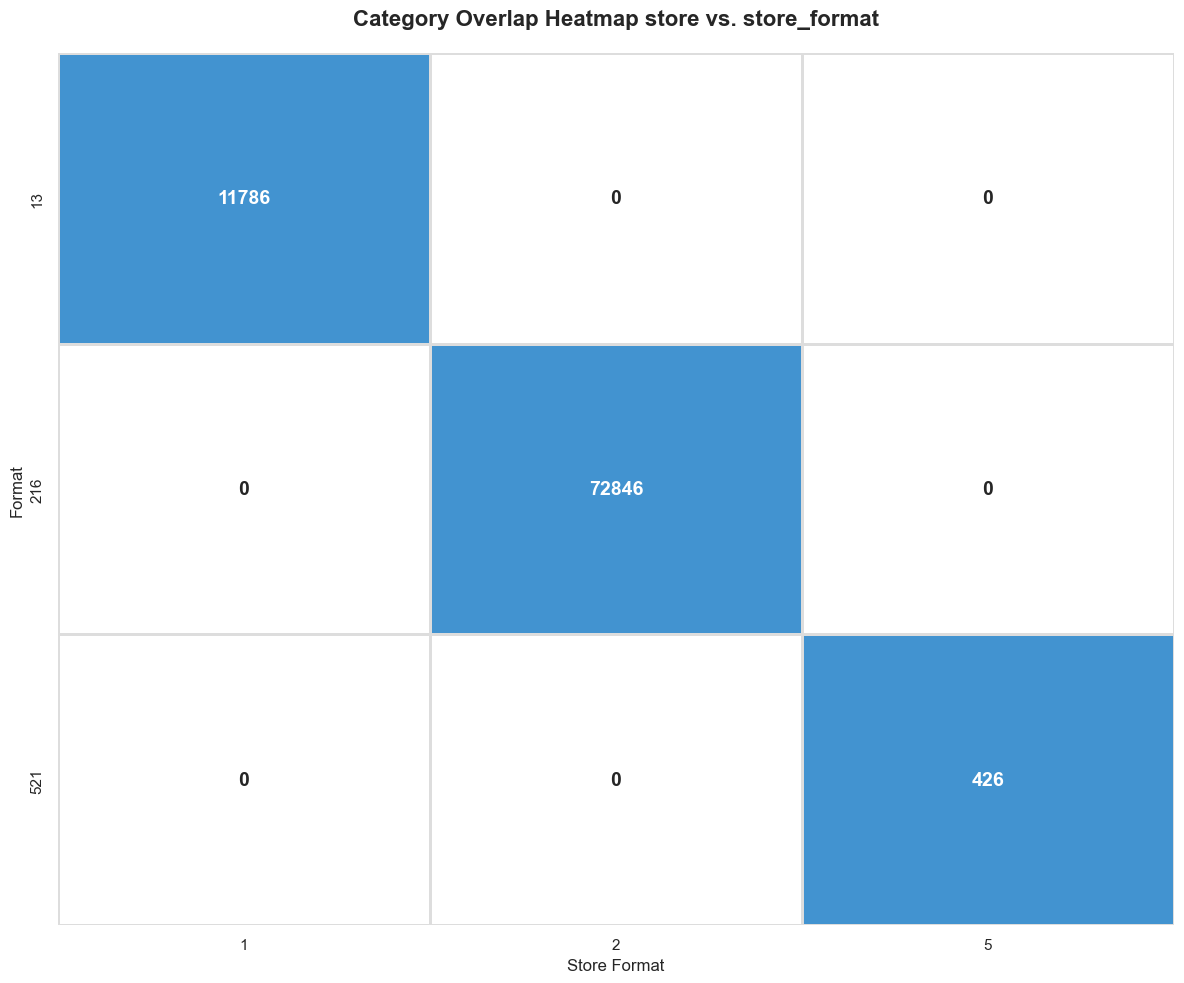

In [9]:
contingency_table = pd.crosstab(df_train['format'], df_train['store_format'])

target_blue = "#4293D0"
binary_cmap = ListedColormap(['#ffffff', target_blue])

plt.figure(figsize=(12, 10))

# Create the heatmap
sns.heatmap(contingency_table, 
            annot=True, 
            fmt='d', 
            cmap=binary_cmap, 
            vmin=0, 
            vmax=1, 
            cbar=False, 
            linewidths=1, 
            linecolor='#DDDDDD',
            # Set font size to 14 and keep it bold for visibility
            annot_kws={"size": 14, "weight": "bold"})

# Spearman correlation
correlation_value = df_train['store_format'].astype('category').cat.codes.corr(
    df_train['format'].astype('category').cat.codes, method='spearman')

plt.title(f'Category Overlap Heatmap store vs. store_format', 
          fontsize=16, 
          pad=20,
          fontweight='bold')

plt.xlabel('Store Format', fontsize=12)
plt.ylabel('Format', fontsize=12)

plt.tight_layout()
plt.savefig("images/correlation_format_store-format.png", dpi=300)
plt.show()

In [10]:
X_train_preprocessed = data_loader.preprocessing(df_train)
X_test_preprocessed = data_loader.preprocessing(df_test)

X_train_preprocessed.dtypes

store_number                 int64
product_number               int64
product_category             int64
business                     int64
department_num               int64
department_group             int64
store_format                 int64
week                datetime64[ns]
sales                      float64
month                        int32
week_of_year                 int64
year                         int64
dtype: object

/var/folders/f2/2y22t7gx2z5gdwk3d89ytmy00000gn/T/ipykernel_52470/1513675734.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  peaks = weekly_sales.groupby('year').apply(lambda x: x.nlargest(2, 'sales')).reset_index(drop=True)


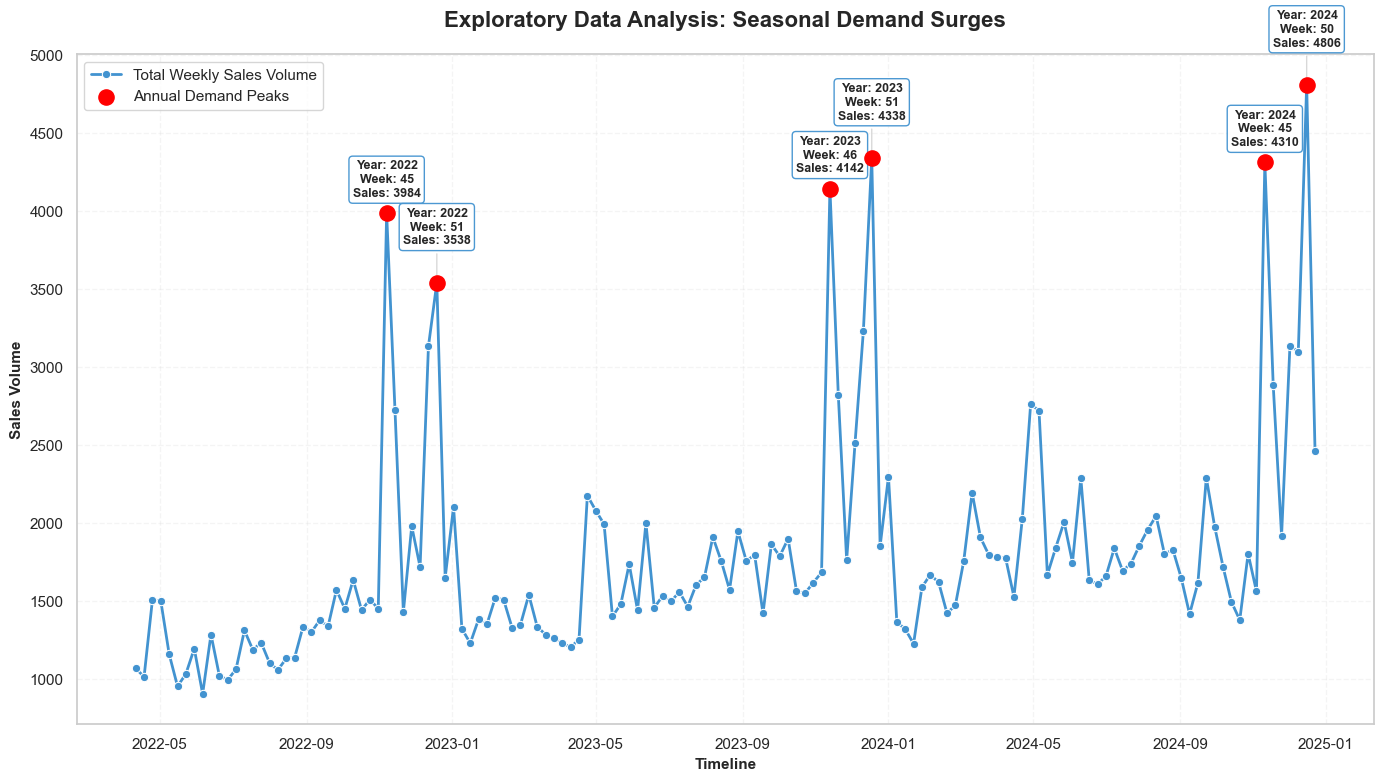

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Prepare Data
X_train_preprocessed['week'] = pd.to_datetime(X_train_preprocessed['week'])
weekly_sales = X_train_preprocessed.groupby(['year', 'week'])['sales'].sum().reset_index()

# 2. Identify Top 2 Peak Weeks per Year
peaks = weekly_sales.groupby('year').apply(lambda x: x.nlargest(2, 'sales')).reset_index(drop=True)
peaks = peaks.sort_values('week')

target_blue = "#4293D0"

plt.figure(figsize=(14, 8))

# 3. Plot the Main Time Series
sns.lineplot(
    data=weekly_sales, 
    x='week', 
    y='sales', 
    marker='o', 
    color=target_blue, 
    linewidth=2, 
    label='Total Weekly Sales Volume'
)

# 4. Highlight the Peak Values
plt.scatter(peaks['week'], peaks['sales'], color='red', s=120, zorder=5, label='Annual Demand Peaks')

# 5. Tightened Annotations (Smaller gap between box and plot)
for i, (_, row) in enumerate(peaks.iterrows()):
    week_num = row['week'].strftime('%U')
    
    # Significantly smaller offsets to pull the boxes closer to the points
    y_offset = 12 if i % 2 == 0 else 28
    
    plt.annotate(
        f"Year: {int(row['year'])}\nWeek: {week_num}\nSales: {int(row['sales'])}",
        xy=(row['week'], row['sales']),
        xytext=(0, y_offset), 
        textcoords='offset points',
        ha='center',
        fontsize=9,
        fontweight='bold',
        # Subtle arrow to maintain the link without clutter
        arrowprops=dict(arrowstyle='-', color='gray', alpha=0.3),
        # Professional thin-border box in your target blue
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=target_blue, lw=1, alpha=0.95)
    )

# 6. Final Presentation Styling
plt.title('Exploratory Data Analysis: Seasonal Demand Surges', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Timeline', fontsize=11, fontweight='bold')
plt.ylabel('Sales Volume', fontsize=11, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.2)
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('images/final_time_series_2peaks.png', dpi=300)
plt.show()

## Store Variety

/var/folders/f2/2y22t7gx2z5gdwk3d89ytmy00000gn/T/ipykernel_52470/1369937328.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


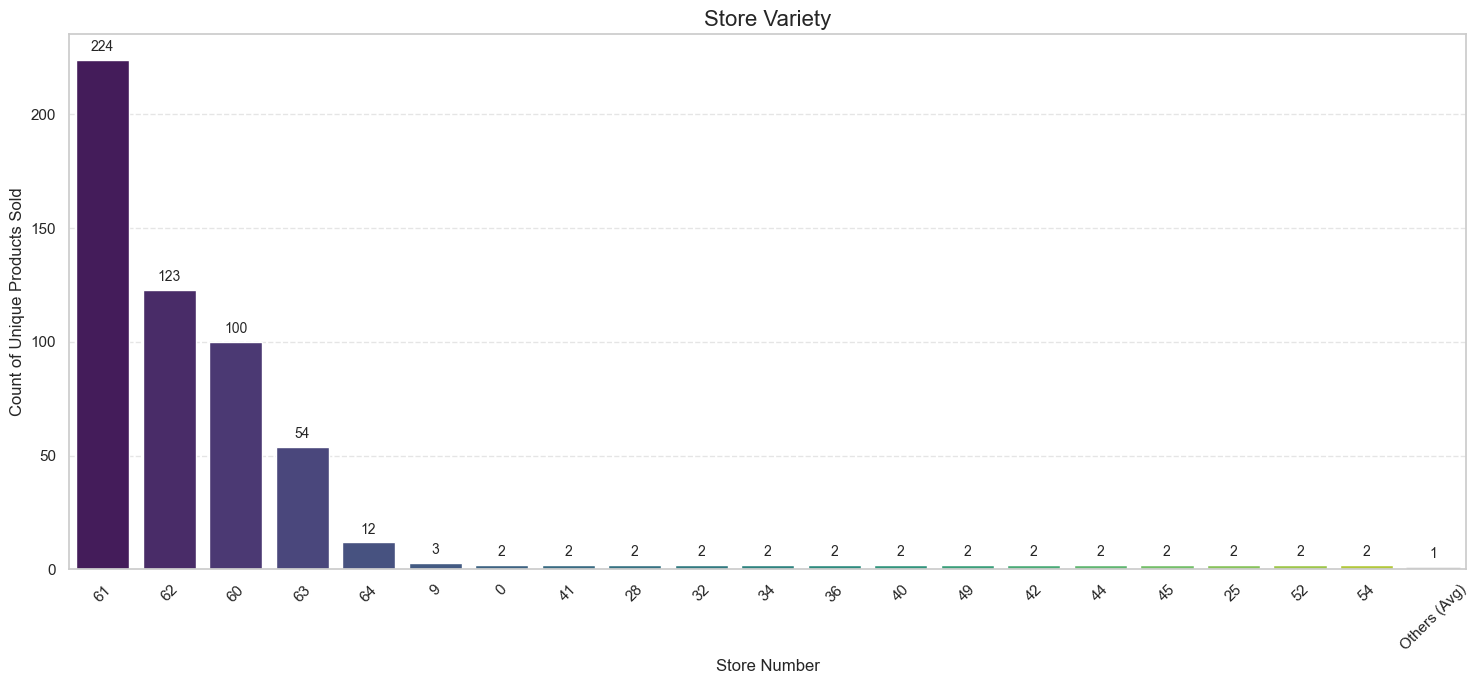

In [12]:
store_total_variety = X_train_preprocessed[X_train_preprocessed['sales'] > 0].groupby('store_number')['product_number'].nunique().sort_values(ascending=False).reset_index()
store_total_variety.columns = ['store_number', 'total_unique_products']

top_n = 20

if len(store_total_variety) > top_n:
    # Extract Top N stores
    top_stores = store_total_variety.head(top_n).copy()

    others_val = store_total_variety.iloc[top_n:]['total_unique_products'].mean()

    # Combine smaller stores
    others_df = pd.DataFrame({
        'store_number': ['Others (Avg)'],
        'total_unique_products': [others_val]
    })

    plot_data = pd.concat([top_stores, others_df], ignore_index=True)
else:
    plot_data = store_total_variety

plt.figure(figsize=(15, 7))
sns.barplot(
    data=plot_data,
    x='store_number',
    y='total_unique_products',
    palette='viridis'
)

if len(store_total_variety) > top_n:
    plt.gca().patches[-1].set_facecolor('gray')
    plt.gca().patches[-1].set_alpha(0.5)

plt.title(f'Store Variety', fontsize=16)
plt.xlabel('Store Number', fontsize=12)
plt.ylabel('Count of Unique Products Sold', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 9),
                       textcoords = 'offset points',
                       fontsize=10)

plt.tight_layout()
plt.savefig('images/store_variety.png')
plt.show()

/var/folders/f2/2y22t7gx2z5gdwk3d89ytmy00000gn/T/ipykernel_52470/1928865507.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_train_preprocessed, x='store_format', y='sales', palette='Set2')


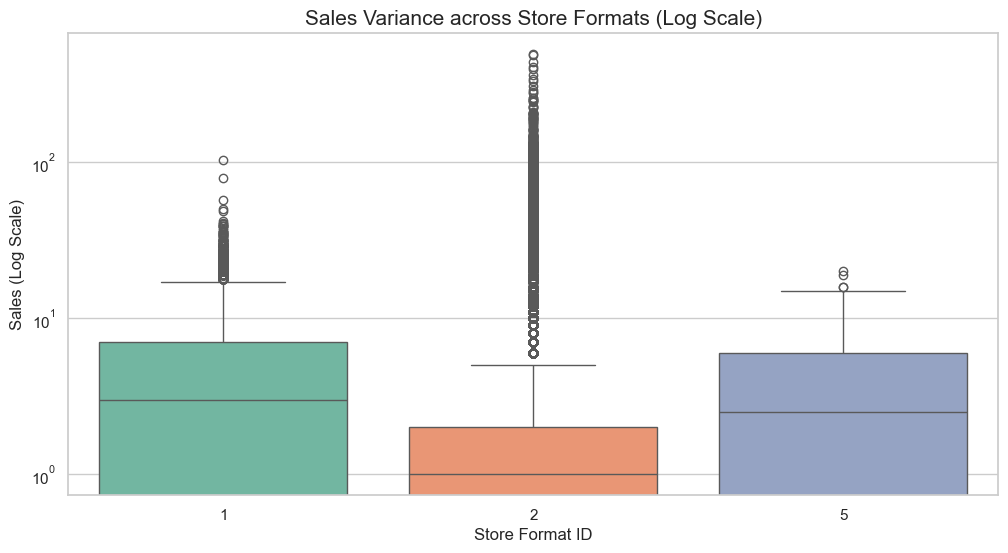

In [13]:
plt.figure(figsize=(12, 6))

sns.boxplot(data=X_train_preprocessed, x='store_format', y='sales', palette='Set2')
plt.yscale('log')
plt.title('Sales Variance across Store Formats (Log Scale)', fontsize=15)
plt.xlabel('Store Format ID')
plt.ylabel('Sales (Log Scale)')
plt.savefig('images/boxplot_store_format_variance.png')
plt.show()

/var/folders/f2/2y22t7gx2z5gdwk3d89ytmy00000gn/T/ipykernel_52470/163496920.py:28: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


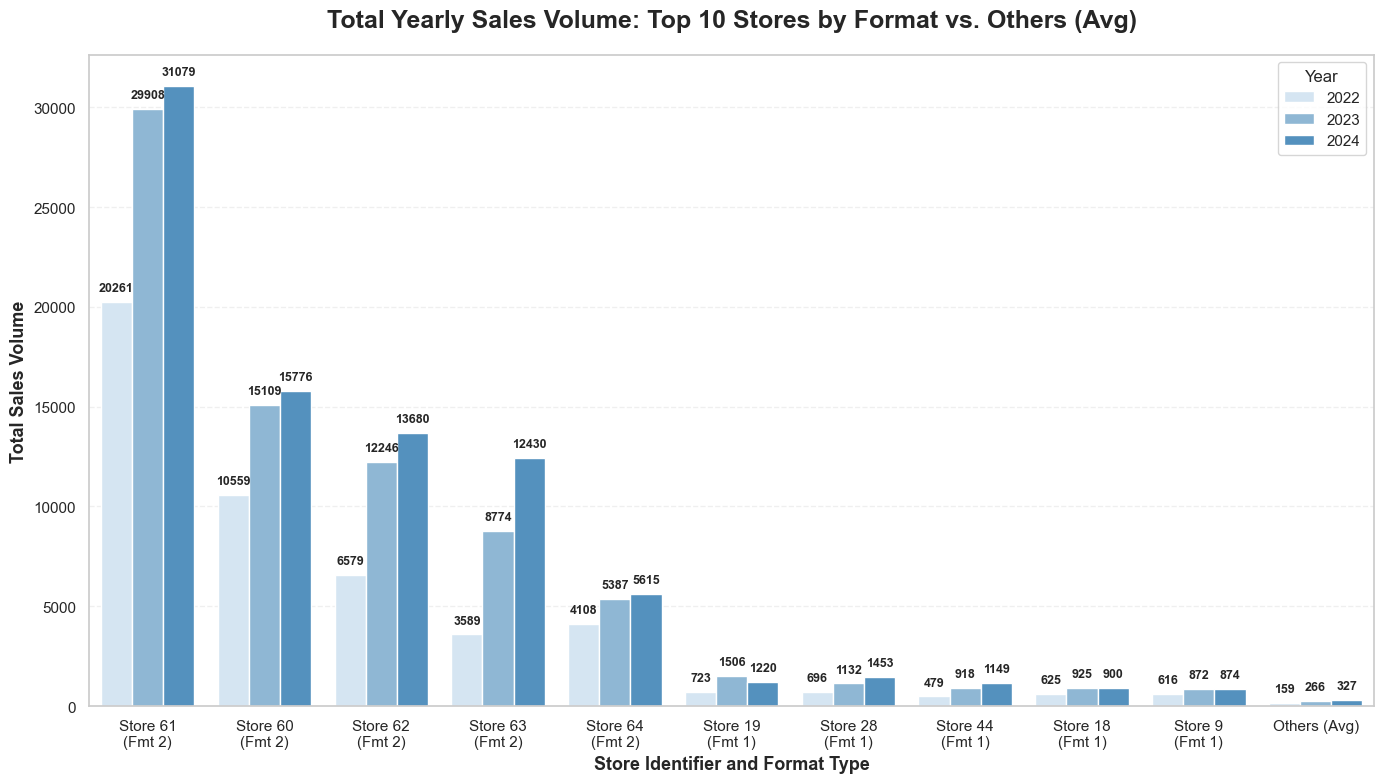

In [14]:
store_format_mapping = X_train_preprocessed[['store_number', 'store_format']].drop_duplicates()
store_yearly_sales = X_train_preprocessed.groupby(['store_number', 'year'])['sales'].sum().reset_index()

top_n = 10
top_stores_list = store_yearly_sales.groupby('store_number')['sales'].sum().nlargest(top_n).index

top_stores_df = store_yearly_sales[store_yearly_sales['store_number'].isin(top_stores_list)].copy()
top_stores_df = top_stores_df.merge(store_format_mapping, on='store_number', how='left')

top_stores_df['display_label'] = "Store " + top_stores_df['store_number'].astype(str) + \
                                 "\n(Fmt " + top_stores_df['store_format'].astype(str) + ")"

others_df = store_yearly_sales[~store_yearly_sales['store_number'].isin(top_stores_list)].copy()
others_yearly = others_df.groupby('year')['sales'].mean().reset_index()
others_yearly['display_label'] = 'Others (Avg)'

plot_data = pd.concat([top_stores_df, others_yearly], ignore_index=True)

order = top_stores_df.groupby('display_label')['sales'].sum().sort_values(ascending=False).index.tolist()
order.append('Others (Avg)')

target_blue = "#4293D0"
num_years = plot_data['year'].nunique()
colors_list = ["#D0E6F7", "#84B9E0", target_blue]
custom_palette = LinearSegmentedColormap.from_list("custom_blues", colors_list)(np.linspace(0, 1, num_years))

plt.figure(figsize=(14, 8))
sns.barplot(
    data=plot_data,
    x='display_label',
    y='sales',
    hue='year',
    palette=custom_palette, 
    order=order
)

plt.title(f'Total Yearly Sales Volume: Top {top_n} Stores by Format vs. Others (Avg)', 
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Store Identifier and Format Type', fontsize=13, fontweight='bold')
plt.ylabel('Total Sales Volume', fontsize=13, fontweight='bold')
plt.legend(title='Year', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.3)

for p in plt.gca().patches:
    height = p.get_height()
    if height > 0:
        plt.gca().annotate(f'{int(height)}',
                           (p.get_x() + p.get_width() / 2., height),
                           ha='center', va='center',
                           xytext=(0, 10),
                           textcoords='offset points',
                           fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('images/yearly_sales_volume_stores.png')
plt.show()

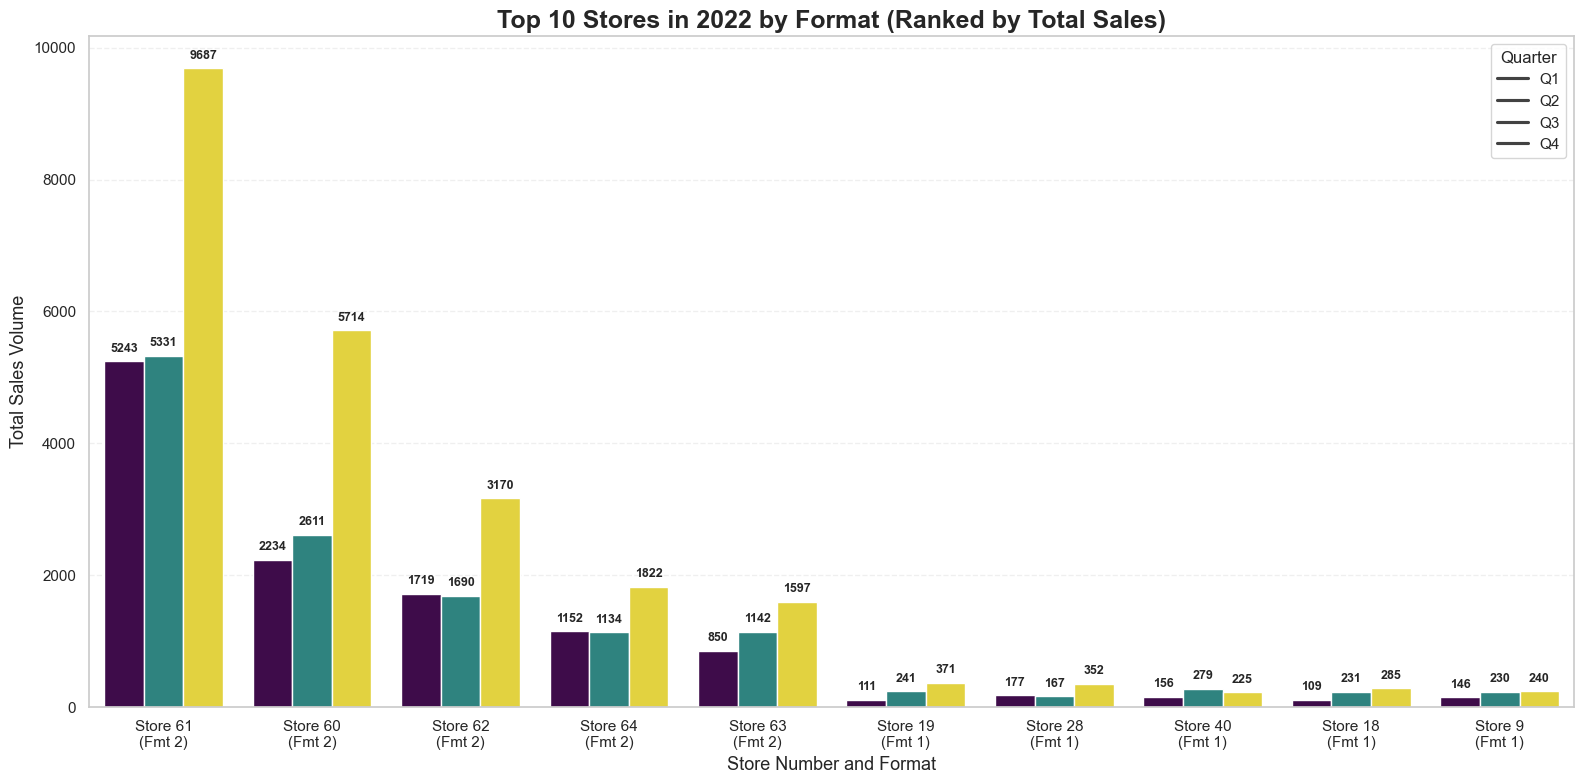

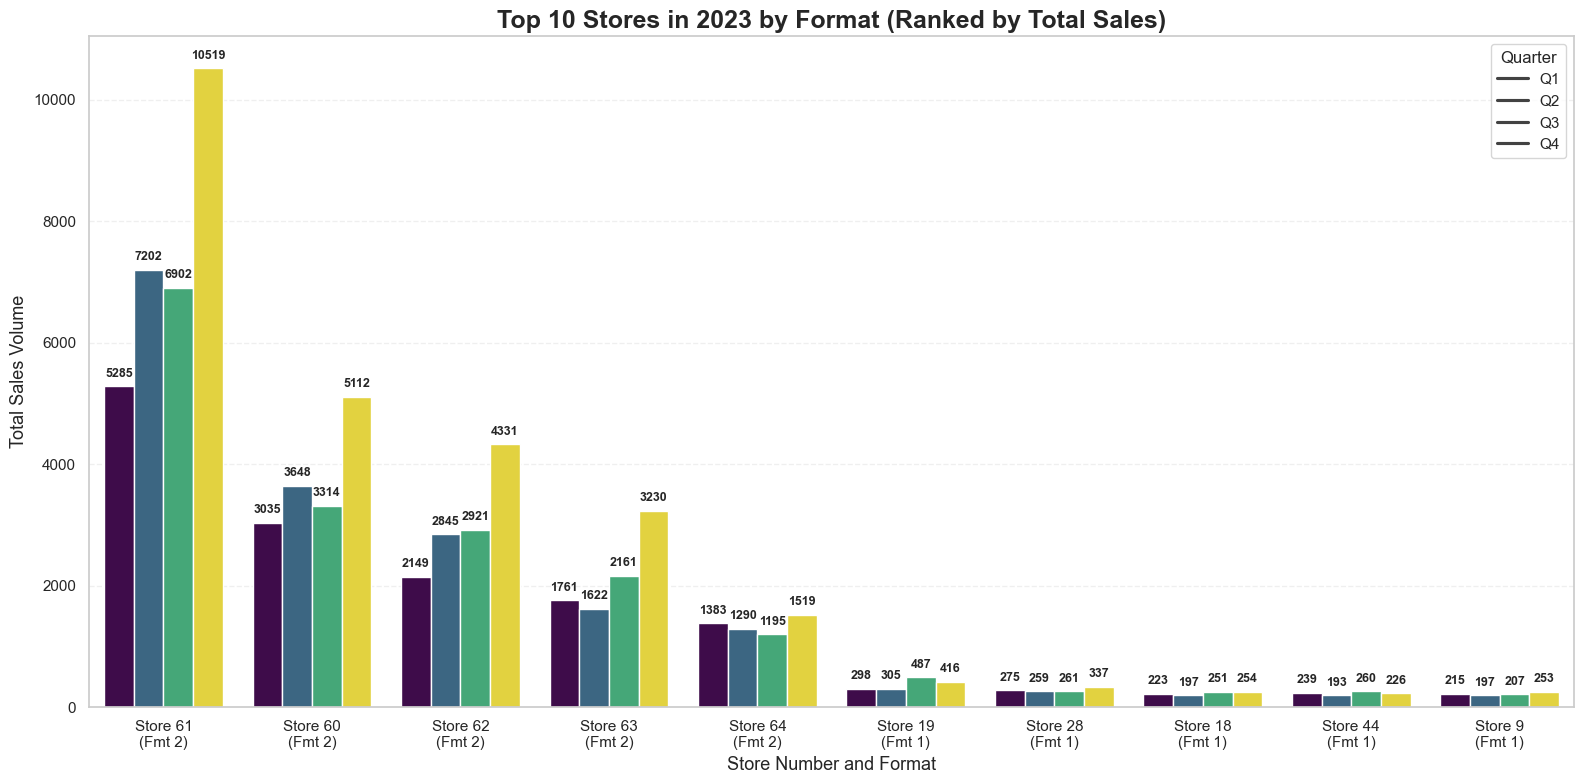

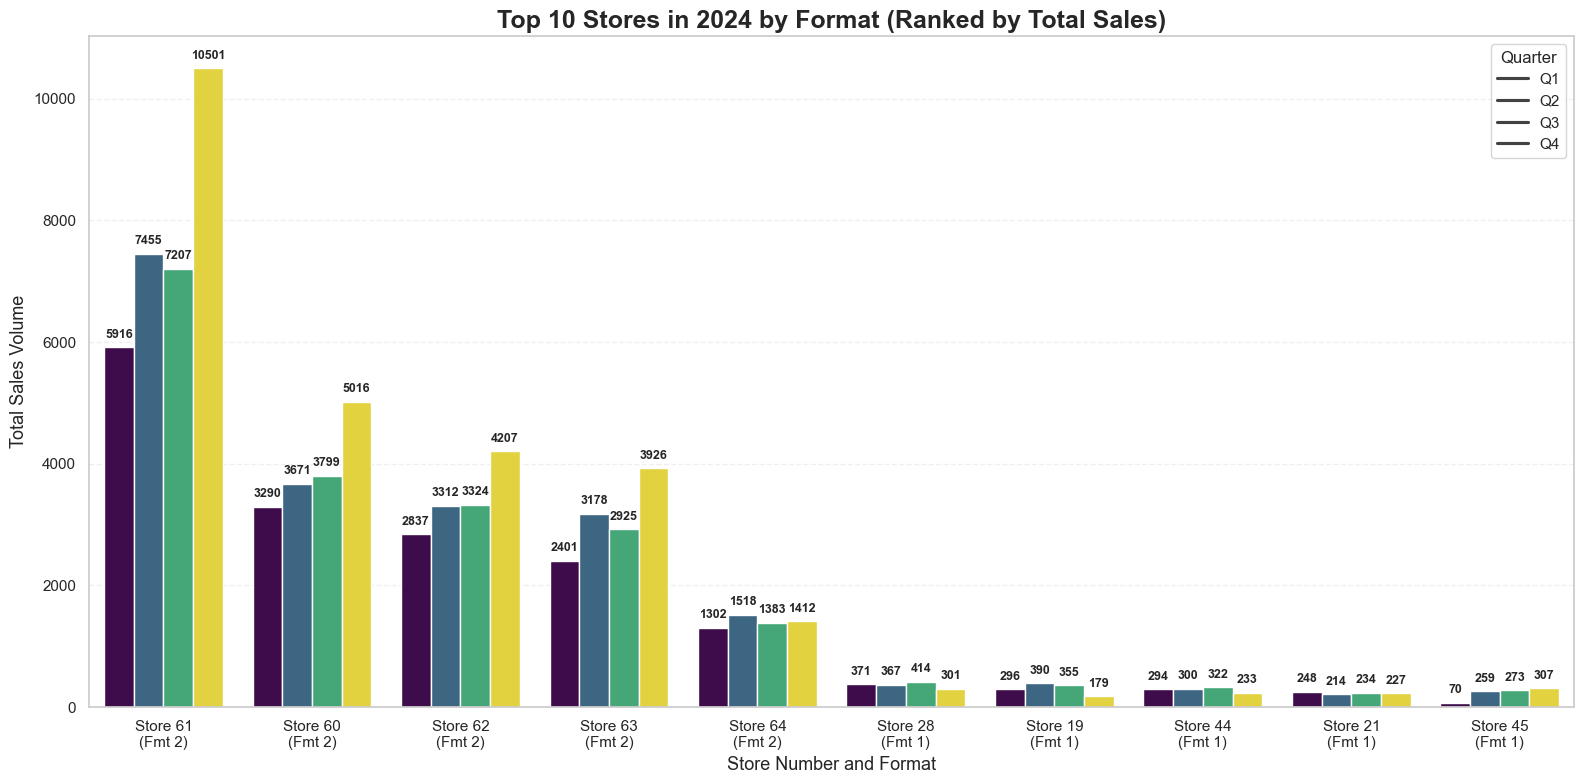

In [15]:
# Ensure time features and mapping exist
if 'quarter' not in X_train_preprocessed.columns:
    X_train_preprocessed['quarter'] = X_train_preprocessed['week'].dt.quarter

# Create a unique mapping of store numbers to their formats
store_fmt_map = X_train_preprocessed[['store_number', 'store_format']].drop_duplicates()

# Aggregation
yearly_store_stats = X_train_preprocessed.groupby(['year', 'store_number', 'quarter'])['sales'].sum().reset_index()

# Iterate through years
years = sorted(yearly_store_stats['year'].unique())

for year in years:
    # Filter for the specific year
    year_data = yearly_store_stats[yearly_store_stats['year'] == year].copy()

    # Identify top 10 stores for this specific year
    current_year_order = year_data.groupby('store_number')['sales'].sum().nlargest(10).index.tolist()

    # Merge format info and filter for top 10
    plot_data = year_data[year_data['store_number'].isin(current_year_order)].copy()
    plot_data = plot_data.merge(store_fmt_map, on='store_number', how='left')

    # Create a combined label for the X-axis: "Store ID (Format)"
    plot_data['display_label'] = "Store " + plot_data['store_number'].astype(str) + \
                                 "\n(Fmt " + plot_data['store_format'].astype(str) + ")"

    # Re-calculate the order based on the new labels to keep the ranking
    label_order = [f"Store {s}\n(Fmt {store_fmt_map[store_fmt_map['store_number']==s]['store_format'].values[0]})"
                   for s in current_year_order]

    # 4. Plotting
    plt.figure(figsize=(16, 8))
    sns.barplot(
        data=plot_data,
        x="display_label",
        y="sales",
        hue="quarter",
        palette="viridis",
        order=label_order
    )

    # Styling
    plt.title(f'Top 10 Stores in {year} by Format (Ranked by Total Sales)', fontsize=18, fontweight='bold')
    plt.xlabel('Store Number and Format', fontsize=13)
    plt.ylabel('Total Sales Volume', fontsize=13)
    plt.legend(title="Quarter", labels=['Q1', 'Q2', 'Q3', 'Q4'], loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    # Value Labels
    for p in plt.gca().patches:
        height = p.get_height()
        if height > 0:
            plt.gca().annotate(f'{int(height)}',
                               (p.get_x() + p.get_width() / 2., height),
                               ha='center', va='center',
                               xytext=(0, 9),
                               textcoords='offset points',
                               fontsize=9,
                               fontweight='bold')

    plt.tight_layout()
    save_path = f'images/top_stores_{year}.png'
    plt.savefig(save_path)
    plt.show()

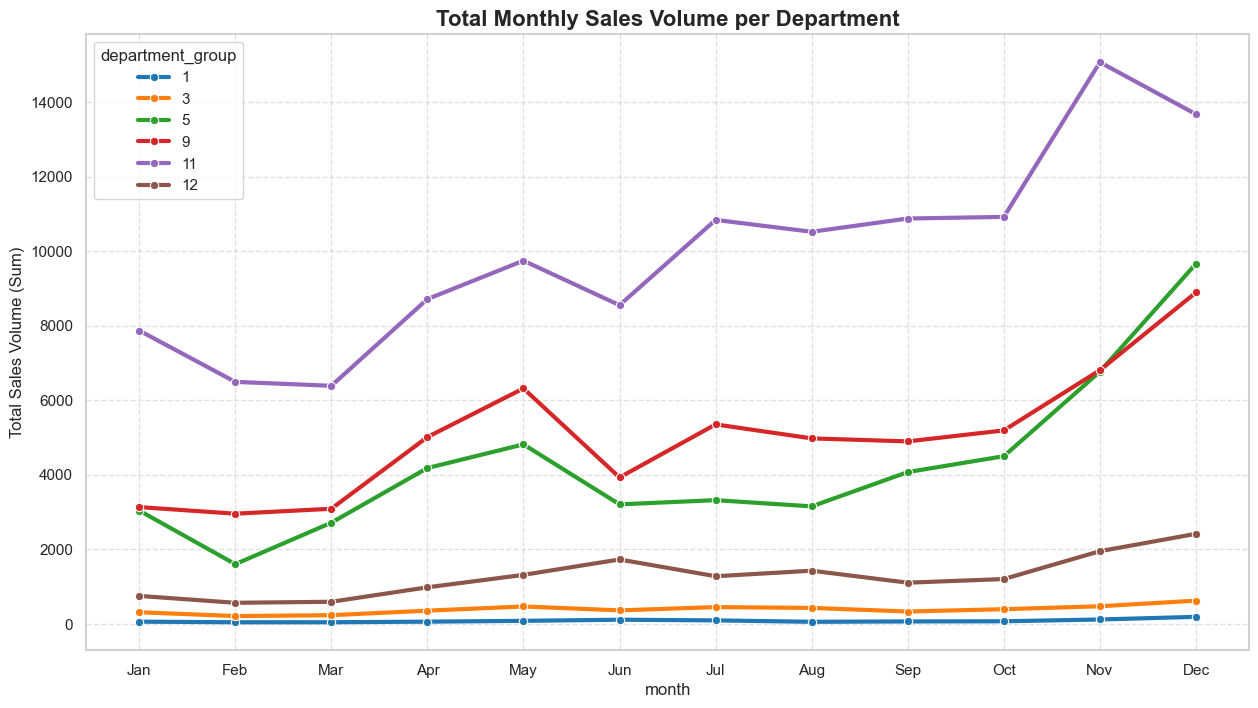

In [16]:
seasonal_sum = X_train_preprocessed.groupby(['department_group', 'month'])['sales'].sum().reset_index()

top_depts = X_train_preprocessed.groupby('department_group')['sales'].sum().index
plot_data = seasonal_sum[seasonal_sum['department_group'].isin(top_depts)]

plt.figure(figsize=(15, 8))
sns.lineplot(
    data=plot_data,
    x='month',
    y='sales',
    hue='department_group',
    marker='o',
    linewidth=3,
    palette="tab10"
)

plt.title('Total Monthly Sales Volume per Department', fontsize=16, fontweight='bold')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Total Sales Volume (Sum)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("images/montly_sales_per_department.png")
plt.show()

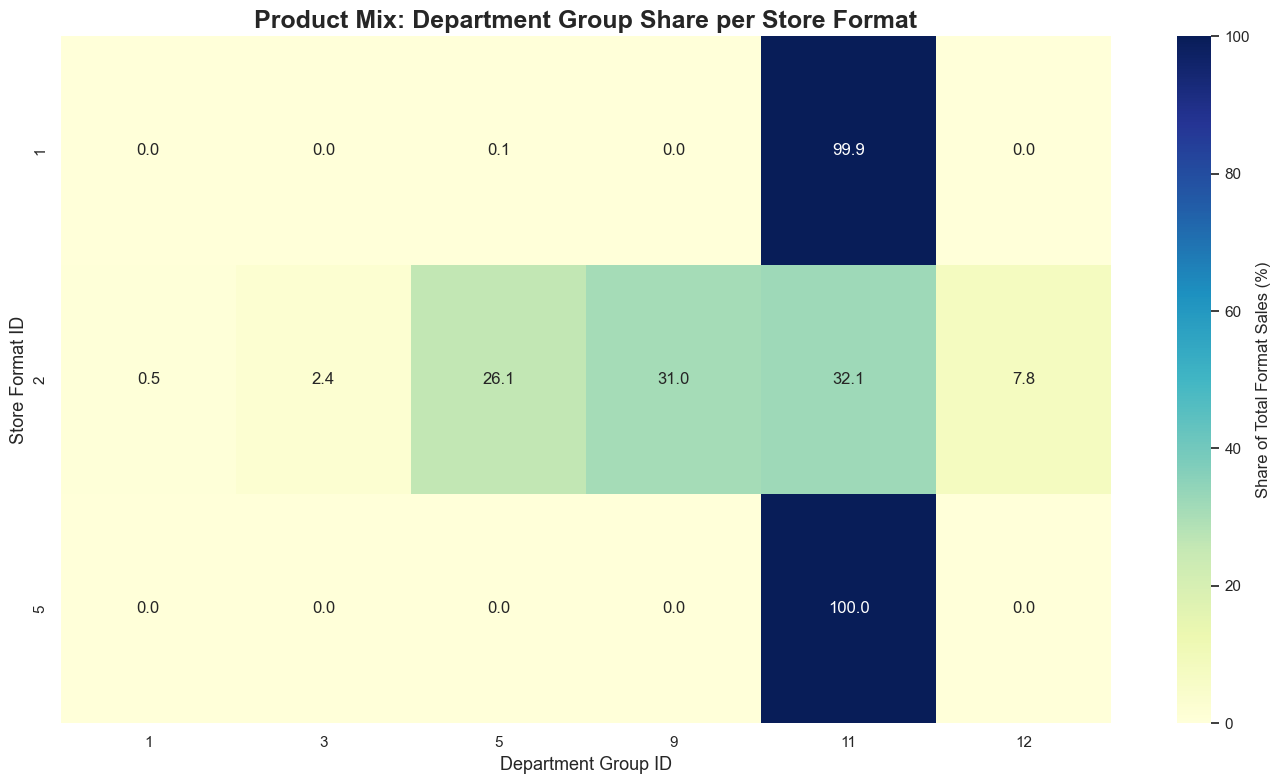

In [17]:
format_dept_sales = X_train_preprocessed.groupby(['store_format', 'department_group'])['sales'].sum().reset_index()

pivot_data = format_dept_sales.pivot(index='store_format', columns='department_group', values='sales').fillna(0)

pivot_norm = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_norm, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Share of Total Format Sales (%)'})

plt.title('Product Mix: Department Group Share per Store Format', fontsize=18, fontweight='bold')
plt.xlabel('Department Group ID', fontsize=13)
plt.ylabel('Store Format ID', fontsize=13)

plt.tight_layout()
plt.savefig("images/product_mix_per_store_format.png")
plt.show()

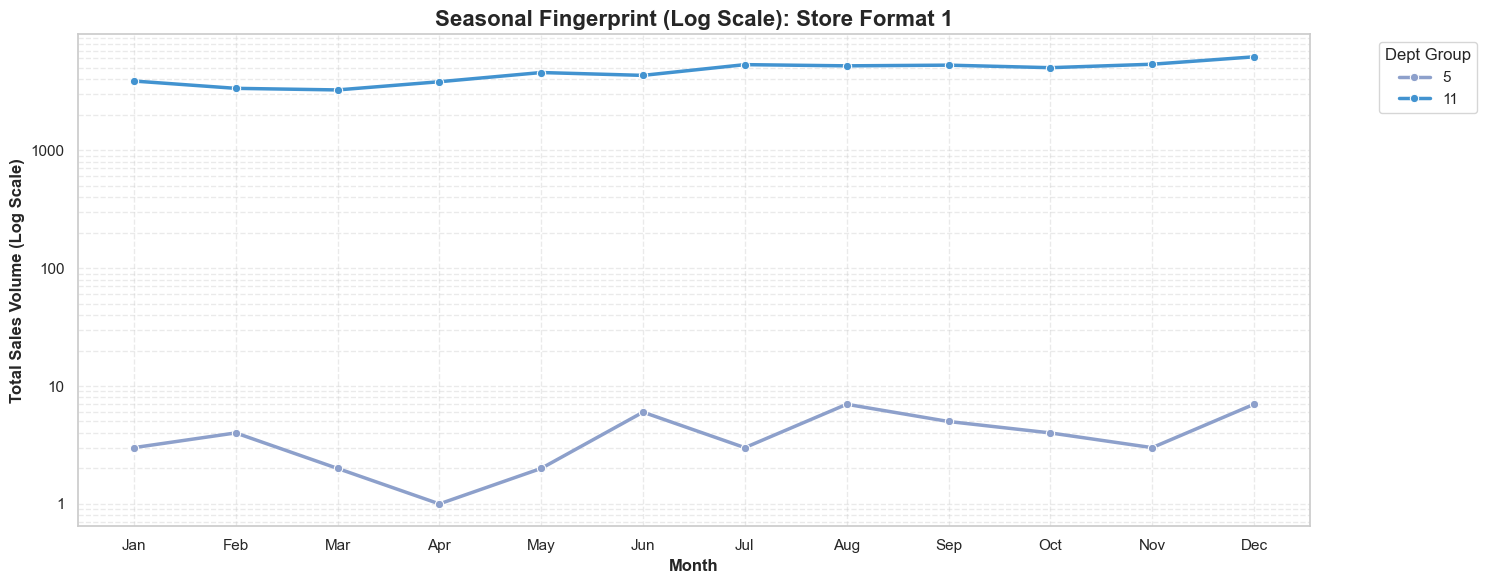

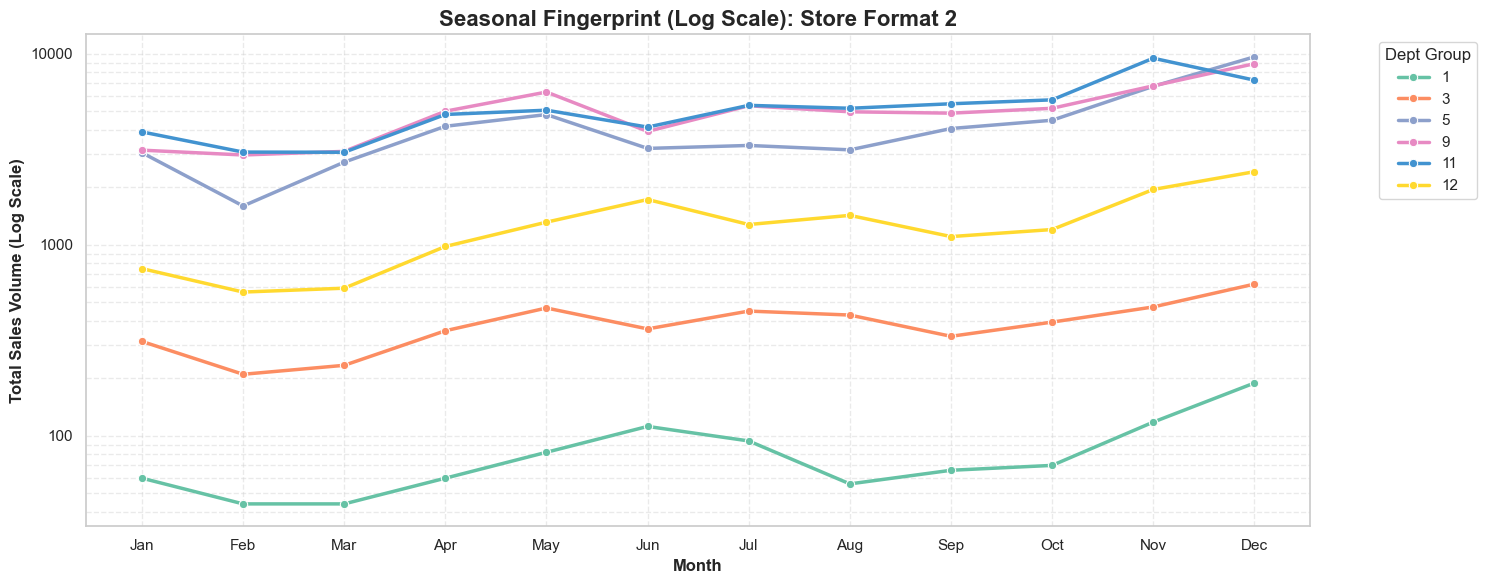

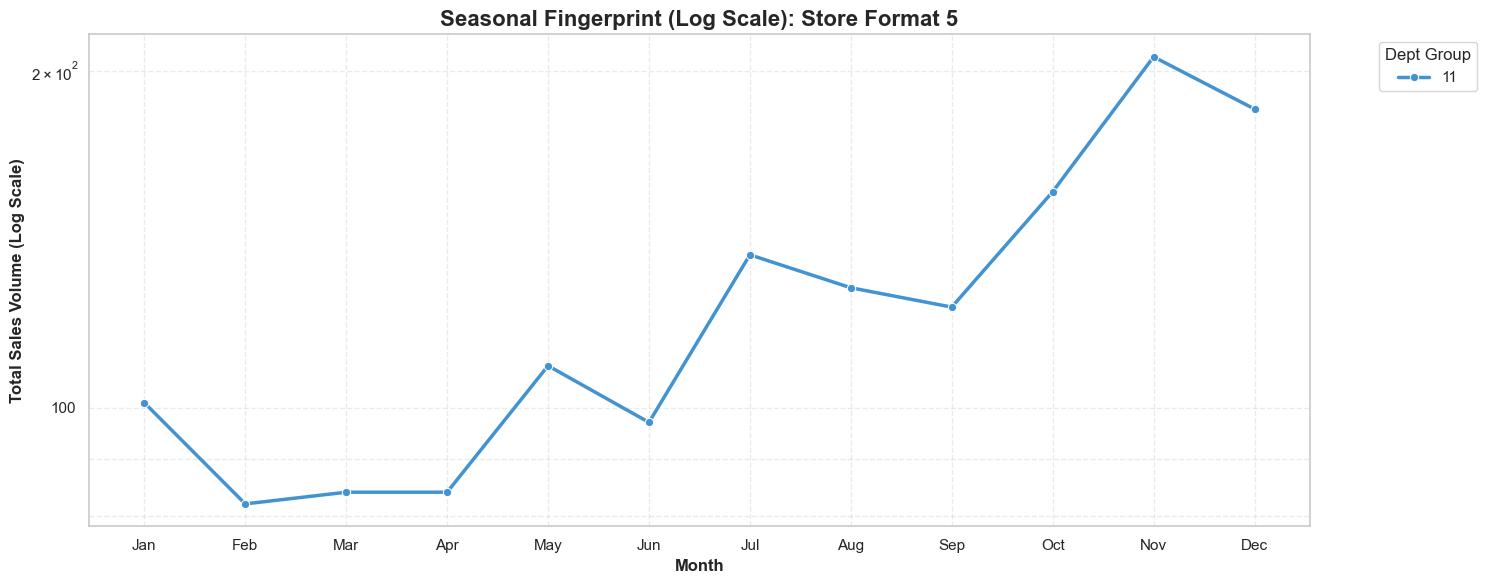

In [18]:
target_blue = "#4293D0"
all_depts = sorted(X_train_preprocessed['department_group'].unique())
base_colors = sns.color_palette("Set2", len(all_depts))
dept_color_map = {dept: base_colors[i] for i, dept in enumerate(all_depts)}

if 11 in dept_color_map:
    dept_color_map[11] = target_blue

unique_formats = sorted(X_train_preprocessed['store_format'].unique())

for fmt in unique_formats:
    format_data = X_train_preprocessed[X_train_preprocessed['store_format'] == fmt]
    fmt_seasonal = format_data.groupby(['department_group', 'month'])['sales'].sum().reset_index()

    plt.figure(figsize=(15, 6))
    
    sns.lineplot(
        data=fmt_seasonal,
        x='month',
        y='sales',
        hue='department_group',
        marker='o',
        linewidth=2.5,
        palette=dept_color_map
    )

    plt.yscale('log')
    
    plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
    plt.gca().yaxis.get_major_formatter().set_scientific(False)
    plt.gca().yaxis.get_major_formatter().set_useOffset(False)

    plt.title(f'Seasonal Fingerprint (Log Scale): Store Format {fmt}', fontsize=16, fontweight='bold')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.ylabel('Total Sales Volume (Log Scale)', fontweight='bold')
    plt.xlabel('Month', fontweight='bold')
    
    plt.grid(True, which="both", linestyle='--', alpha=0.4)

    plt.legend(title='Dept Group', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    save_path = f'images/seasonal_fingerprint_store_format_{fmt}_log.png'
    plt.savefig(save_path)
    plt.show()

## Feature Engineering

In [19]:
X_train_engineered = data_loader.feature_engineering(X_train_preprocessed)
X_train_engineered.describe()

,store_number,product_number,product_category,business,department_num,department_group,store_format,week,sales,month,...,rolling_std_4_wks,rolling_mean_12_wks,velocity,store_seasonal_avg,cat_seasonal_avg,dept_seasonal_avg,sales_log_return,prod_store_share,perf_vs_store,yoy_growth
count,85058.000000,85058.000000,85058.000000,85058.000000,85058.000000,85058.000000,85058.000000,85058,85058.000000,85058.000000,...,74276.000000,69484.000000,69484.000000,72846.000000,59382.000000,84890.000000,75474.000000,7.607300e+04,65151.000000,5.391000e+04
mean,56.881469,137.766277,309149.320534,3091.442404,30.864775,9.001669,1.876461,2023-08-17 11:59:59.999999744,2.964413,6.866197,...,1.737603,2.873261,0.956172,2.842173,2.705913,2.965433,0.002152,8.359471e+05,1.022792,6.902806e+05
min,0.000000,0.000000,20318.000000,203.000000,2.000000,1.000000,1.000000,2022-04-11 00:00:00,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.099567,0.000000,0.000000,-4.653960,0.000000e+00,0.000000,0.000000e+00
25%,60.000000,68.000000,200606.000000,2006.000000,20.000000,9.000000,2.000000,2022-12-12 00:00:00,0.000000,4.000000,...,0.500000,0.583333,0.500000,1.949153,0.833333,1.346237,-0.405465,0.000000e+00,0.000000,0.000000e+00
50%,61.000000,126.000000,301202.000000,3012.000000,30.000000,9.000000,2.000000,2023-08-17 12:00:00,1.000000,7.000000,...,0.957427,1.083333,0.934171,2.287719,1.266667,1.795745,0.000000,2.066116e-03,0.253472,6.363636e-01
75%,62.000000,209.000000,401001.000000,4010.000000,40.000000,11.000000,2.000000,2024-04-22 00:00:00,2.000000,10.000000,...,1.732051,2.083333,1.333332,2.946237,2.986395,4.728571,0.405465,9.174312e-03,0.784053,1.899998e+01
max,66.000000,296.000000,590001.000000,5900.000000,59.000000,12.000000,5.000000,2024-12-23 00:00:00,494.000000,12.000000,...,203.021345,190.666667,3.000000,26.333333,36.833333,15.558685,4.890349,2.500000e+08,302.548612,1.110000e+08
std,12.857362,83.702915,144710.632028,1447.119085,14.467367,2.700105,0.410341,NaN,10.595799,3.297968,...,4.489321,8.546508,0.661086,2.032836,3.611927,2.322635,0.725240,3.953342e+06,4.468564,2.603973e+06


In [20]:
"""import pandas as pd

# Assuming X_train_preprocessed is your DataFrame
output_filename = 'preprocessed_train_data.xlsx'

# Save to Excel
# index=False prevents pandas from writing the row numbers as a separate column
X_train_preprocessed.to_excel(output_filename, index=False)

print(f"Data successfully saved to {output_filename}")"""

'import pandas as pd\n\n# Assuming X_train_preprocessed is your DataFrame\noutput_filename = \'preprocessed_train_data.xlsx\'\n\n# Save to Excel\n# index=False prevents pandas from writing the row numbers as a separate column\nX_train_preprocessed.to_excel(output_filename, index=False)\n\nprint(f"Data successfully saved to {output_filename}")'

## Data Preparation for Model Training

In [21]:
date_col = data_loader.get_date_col()
target_col = data_loader.get_target_col()

X_train_engineered = X_train_engineered.sort_values(by=date_col)

X_train_chronos = X_train_engineered.copy()

X_train_full = X_train_engineered.drop(columns=[target_col, "week", "quarter", "week_of_year", "month"])
y_train_full = X_train_engineered[target_col]

# Define Categorical Data
categorical_features = [
    'store_number', 'product_number', 'product_category',
    'business', 'department_num', 'department_group',
    'store_format'
]

for col in categorical_features:
    if col in X_train_full.columns:
        X_train_full[col] = X_train_full[col].astype('category')

horizon = 15
x_fold_cv = 3

## Chronos-2 Model Performance

In [22]:
X_train_chronos['id'] = X_train_chronos['store_number'].astype(str) + '_' + X_train_chronos['product_number'].astype(str)

results = {}
final_models = {}

all_dates = sorted(X_train_chronos[date_col].unique())
cv_rmses = []

pipeline = Chronos2Pipeline.from_pretrained("amazon/chronos-2", device_map="mps")

useful_covariates = [
    'id', date_col,
    'week_sin', 'week_cos',
    'dept_seasonal_avg',
    'velocity',
    'yoy_growth'
]

print(f"\nStarting Cross-Validation for Chronos-2")

for i in range(x_fold_cv):
    test_start_idx = len(all_dates) - (horizon * (i + 1))
    test_end_idx = test_start_idx + horizon

    cutoff_date = all_dates[test_start_idx]
    end_date = all_dates[test_end_idx - 1]

    context_df = X_train_chronos[X_train_chronos[date_col] < cutoff_date].copy()
    context_df = context_df.groupby('id').tail(52)

    ground_truth = X_train_chronos[(X_train_chronos[date_col] >= cutoff_date) &
                                   (X_train_chronos[date_col] <= end_date)].copy()
    future_df = ground_truth.drop(columns=[target_col]).copy()

    future_df = ground_truth[useful_covariates].copy()

    # Generate Forecasts
    pred_df = pipeline.predict_df(
        context_df,
        future_df=future_df,
        prediction_length=horizon,
        quantile_levels=[0.5], # Median for point forecast
        id_column="id",
        timestamp_column=date_col,
        target=target_col,
        batch_size=64
    )

    comparison = ground_truth.merge(pred_df[['id', date_col, '0.5']], on=['id', date_col])
    window_rmse = root_mean_squared_error(comparison[target_col], comparison['0.5'])
    cv_rmses.append(window_rmse)

    print(f"Fold {i + 1}: Cutoff {cutoff_date.date()} | RMSE: {window_rmse:.4f}")

    if i == 0:  # i=0 is the most recent window in your n_windows loop
        final_models['Chronos-2'] = pipeline
        # Optional: store the final validation comparison for plotting
        X_val_chronos_final = ground_truth
        y_val_chronos_final = ground_truth[target_col]

# Final Evaluation
average_rmse_chronos = np.mean(cv_rmses)
results['Chronos-2'] = average_rmse_chronos
print(f"\nAverage CV RMSE for Chronos-2: {average_rmse_chronos:.4f}")


Starting Cross-Validation for Chronos-2
Fold 1: Cutoff 2024-09-16 | RMSE: 8.2040
Fold 2: Cutoff 2024-06-03 | RMSE: 3.6846
Fold 3: Cutoff 2024-02-19 | RMSE: 5.4486

Average CV RMSE for Chronos-2: 5.7791


## Boost Model Performance

In [23]:
rows_per_week = X_train_engineered.groupby(date_col).size().iloc[0]
horizon_rows = int(rows_per_week * horizon)

tscv = TimeSeriesSplit(n_splits=x_fold_cv, test_size=horizon_rows)

# Cross-Validation Loop
models_to_test = ['CatBoost', 'XGBoost', 'LightGBM']

for model_name in models_to_test:
    fold_errors = []
    print(f"\nStarting Cross-Validation for {model_name}")

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_full)):
        val_dates = X_train_engineered.iloc[val_idx][date_col]

        X_tr, X_va = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
        y_tr, y_va = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

        if model_name == 'CatBoost':
            m = CatBoostRegressor(
                iterations=1500, learning_rate=0.05, depth=6,
                loss_function='RMSE', random_seed=42, verbose=False,
                early_stopping_rounds=50
            )
            m.fit(X_tr, y_tr, cat_features=categorical_features, eval_set=(X_va, y_va))

        elif model_name == 'XGBoost':
            m = xgb.XGBRegressor(
                n_estimators=1500, learning_rate=0.05, max_depth=6,
                objective='reg:squarederror', enable_categorical=True,
                tree_method='hist', random_state=42, verbosity=0
            )
            m.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

        elif model_name == 'LightGBM':
            m = lgb.LGBMRegressor(
                n_estimators=1500, learning_rate=0.05,
                objective='regression', metric='rmse',
                random_state=42, verbose=-1
            )
            m.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], callbacks=[lgb.early_stopping(50)])

        # Calculate RMSE for this fold
        fold_rmse = root_mean_squared_error(y_va, m.predict(X_va))
        fold_errors.append(fold_rmse)

        print(f"Fold {fold + 1}: Cutoff {val_dates.min().date()} | RMSE: {fold_rmse:.4f}")

        # Store the model and data from the latest fold
        if fold == tscv.n_splits - 1:
            final_models[model_name] = m
            X_val_final, y_val_final, val_dates_final = X_va, y_va, val_dates

    results[model_name] = np.mean(fold_errors)
    print(f"\nAverage CV RMSE for {model_name}: {results[model_name]:.4f}")

# Final Results
winner_name = min(results, key=results.get)

cat_model = final_models.get('CatBoost')
xgb_model = final_models.get('XGBoost')
lgb_model = final_models.get('LightGBM')


Starting Cross-Validation for CatBoost
Fold 1: Cutoff 2024-02-19 | RMSE: 4.9845
Fold 2: Cutoff 2024-06-03 | RMSE: 3.3539
Fold 3: Cutoff 2024-09-16 | RMSE: 7.2862

Average CV RMSE for CatBoost: 5.2082

Starting Cross-Validation for XGBoost
Fold 1: Cutoff 2024-02-19 | RMSE: 5.4862
Fold 2: Cutoff 2024-06-03 | RMSE: 3.6858
Fold 3: Cutoff 2024-09-16 | RMSE: 8.6635

Average CV RMSE for XGBoost: 5.9452

Starting Cross-Validation for LightGBM
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[122]	valid_0's rmse: 5.22907
Fold 1: Cutoff 2024-02-19 | RMSE: 5.2291
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's rmse: 3.36482
Fold 2: Cutoff 2024-06-03 | RMSE: 3.3648
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[128]	valid_0's rmse: 8.06854
Fold 3: Cutoff 2024-09-16 | RMSE: 8.0685

Average CV RMSE for LightGBM: 5.5541


## Results

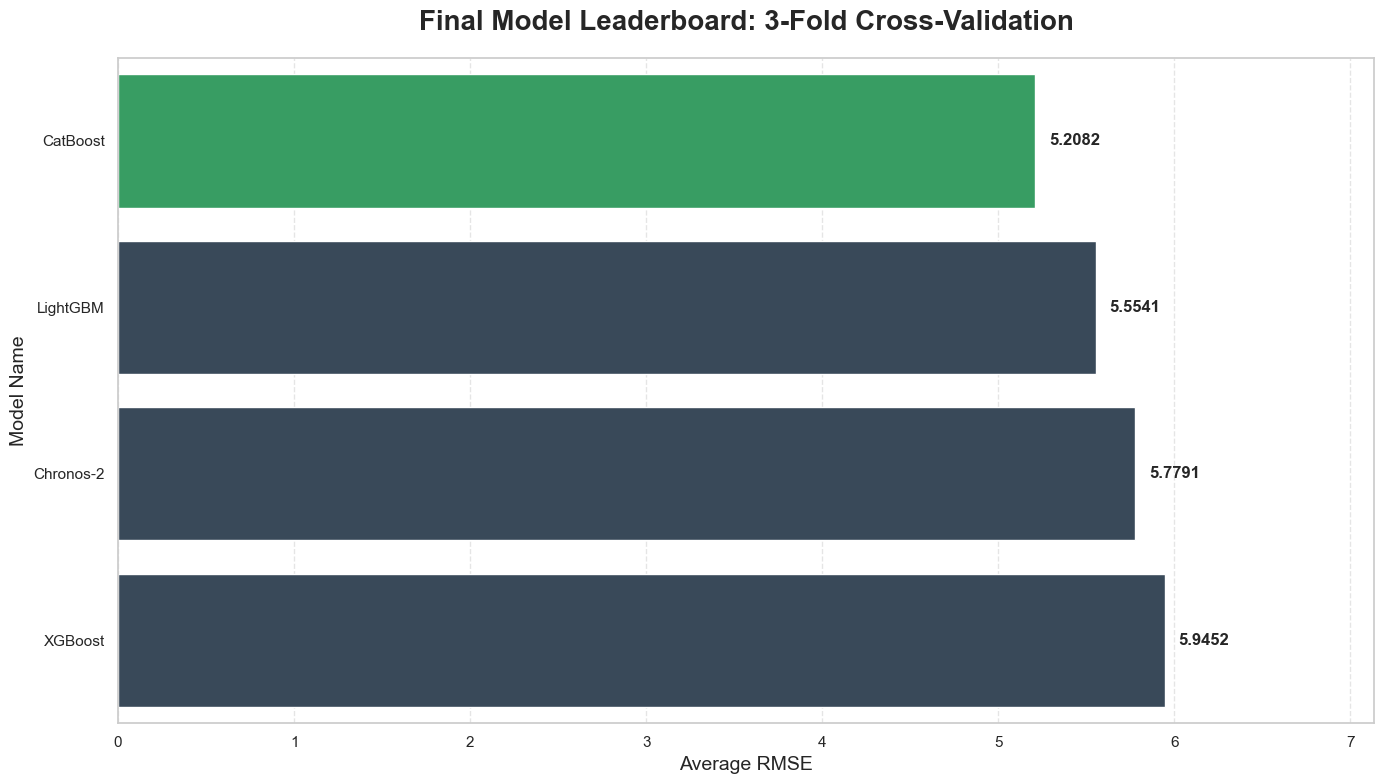

Overall Champion: CatBoost


In [24]:
df_leaderboard = pd.DataFrame(list(results.items()), columns=['Model', 'RMSE'])
df_leaderboard = df_leaderboard.sort_values(by='RMSE', ascending=True)

plt.figure(figsize=(14, 8))
winner_overall = df_leaderboard.iloc[0]['Model']
colors = ['#27ae60' if model == winner_overall else '#34495e' for model in df_leaderboard['Model']]

ax = sns.barplot(
    data=df_leaderboard,
    x='RMSE',
    y='Model',
    palette=colors,
    hue='Model',
    legend=False
)

# Bar Labels
for i in ax.containers:
    ax.bar_label(i, fmt='%.4f', padding=10, fontsize=12, fontweight='bold')

plt.title('Final Model Leaderboard: 3-Fold Cross-Validation', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Average RMSE', fontsize=14)
plt.ylabel('Model Name', fontsize=14)
plt.xlim(0, df_leaderboard['RMSE'].max() * 1.2)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('images/model_leaderboard.png')
plt.show()

print(f"Overall Champion: {winner_overall}")

In [25]:
def objective(trial):
    # Suggest the model type first
    model_type = trial.suggest_categorical('model_type', models_to_test)

    # Shared or model-specific parameters
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
    depth = trial.suggest_int('max_depth', 3, 8)
    l2_reg = trial.suggest_float('l2_reg', 1e-2, 10.0, log=True)

    tscv = TimeSeriesSplit(n_splits=x_fold_cv, test_size=horizon_rows)
    cv_scores = []
    fold_best_ntrees = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_full)):
        X_tr, X_va = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
        y_tr, y_va = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

        if model_type == 'XGBoost':
            model = xgb.XGBRegressor(
                learning_rate=learning_rate, max_depth=depth, reg_lambda=l2_reg,
                n_estimators=1500, early_stopping_rounds=30,
                tree_method='hist', enable_categorical=True,
                random_state=42, verbosity=0
            )
            model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)
            fold_best_ntrees.append(model.best_iteration)

        elif model_type == 'CatBoost':
            model = CatBoostRegressor(
                learning_rate=learning_rate, depth=depth, l2_leaf_reg=l2_reg,
                iterations=1500, early_stopping_rounds=30,
                random_seed=42, verbose=False
            )
            model.fit(X_tr, y_tr, cat_features=categorical_features, eval_set=(X_va, y_va))
            fold_best_ntrees.append(model.get_best_iteration())

        elif model_type == 'LightGBM':
            model = lgb.LGBMRegressor(
                learning_rate=learning_rate, max_depth=depth, reg_lambda=l2_reg,
                n_estimators=1500, random_state=42, verbose=-1
            )
            model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], callbacks=[lgb.early_stopping(30)])
            fold_best_ntrees.append(model.best_iteration_)

        score = root_mean_squared_error(y_va, model.predict(X_va))
        cv_scores.append(score)

        trial.report(np.mean(cv_scores), step=fold)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Save the best iteration average so we can retrain later
    avg_ntree = int(np.mean(fold_best_ntrees))
    trial.set_user_attr("best_ntree", avg_ntree)

    return np.mean(cv_scores)

study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(multivariate=True, seed=42),
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1, max_resource=3, reduction_factor=3
    )
)

study.optimize(objective, n_trials=100)

print(f"Best Model Type: {study.best_params['model_type']}")
print(f"Best RMSE: {study.best_value:.4f}")
print(f"Best Hyperparameters: {study.best_params}")

/Users/luisgrewe/Documents/StockSalesPrediction/.venv/lib/python3.13/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-12-26 15:02:21,778] A new study created in memory with name: no-name-13c9a0e5-b304-4e08-a13e-47704692f0c9
[I 2025-12-26 15:02:23,354] Trial 0 finished with value: 5.157608050624318 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.03968793330444373, 'max_depth': 3, 'l2_reg': 0.029375384576328302}. Best is trial 0 with value: 5.157608050624318.
[I 2025-12-26 15:02:24,810] Trial 1 finished with value: 5.198849874213296 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.051059032093947576, 'max_depth': 3, 'l2_reg': 8.123245085588687}. Best is trial 0 with value: 5.157608050624318.
[I 2025-12-26 15:02:35,372] Trial 2 finished with value: 5.350410248711455 and parameters: {'model_type': 'CatBoost', 'learning_rate': 0.015254

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[344]	valid_0's l2: 25.0541
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[210]	valid_0's l2: 11.7471
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:02:37,879] Trial 3 finished with value: 5.483907282202236 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.013787764619353767, 'max_depth': 4, 'l2_reg': 0.1256277350380703}. Best is trial 0 with value: 5.157608050624318.


Early stopping, best iteration is:
[652]	valid_0's l2: 64.303


[I 2025-12-26 15:02:39,378] Trial 4 finished with value: 5.641861756841128 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.032676417657817626, 'max_depth': 6, 'l2_reg': 0.013783237455007183}. Best is trial 0 with value: 5.157608050624318.
[I 2025-12-26 15:02:43,830] Trial 5 pruned. 


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[188]	valid_0's l2: 22.9842
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[280]	valid_0's l2: 11.1515
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:02:45,121] Trial 6 finished with value: 5.314856442117631 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.027551959649510765, 'max_depth': 3, 'l2_reg': 0.3058656666978527}. Best is trial 0 with value: 5.157608050624318.


Early stopping, best iteration is:
[338]	valid_0's l2: 61.0118


[I 2025-12-26 15:02:45,627] Trial 7 pruned. 


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[51]	valid_0's l2: 27.8635
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[47]	valid_0's l2: 11.2629
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:02:48,053] Trial 8 finished with value: 5.525460796347087 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.05958443469672518, 'max_depth': 8, 'l2_reg': 4.83595277646595}. Best is trial 0 with value: 5.157608050624318.


Early stopping, best iteration is:
[370]	valid_0's l2: 63.0715


[I 2025-12-26 15:02:49,593] Trial 9 pruned. 
[I 2025-12-26 15:02:50,353] Trial 10 pruned. 
[I 2025-12-26 15:02:51,971] Trial 11 finished with value: 5.201768583619903 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.04983051774012821, 'max_depth': 3, 'l2_reg': 6.475153304849837}. Best is trial 0 with value: 5.157608050624318.
[I 2025-12-26 15:02:52,943] Trial 12 pruned. 
[I 2025-12-26 15:02:57,044] Trial 13 pruned. 
[I 2025-12-26 15:02:59,270] Trial 14 pruned. 
[I 2025-12-26 15:03:01,581] Trial 15 pruned. 


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 26.5449
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:03:01,981] Trial 16 pruned. 


Early stopping, best iteration is:
[32]	valid_0's l2: 11.4489


[I 2025-12-26 15:03:06,333] Trial 17 finished with value: 5.330779377317693 and parameters: {'model_type': 'CatBoost', 'learning_rate': 0.0715330069427386, 'max_depth': 3, 'l2_reg': 0.010509566445544417}. Best is trial 0 with value: 5.157608050624318.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[33]	valid_0's l2: 27.8116
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:03:06,728] Trial 18 pruned. 


Early stopping, best iteration is:
[35]	valid_0's l2: 11.4504


[I 2025-12-26 15:03:07,098] Trial 19 pruned. 
[I 2025-12-26 15:03:08,265] Trial 20 finished with value: 5.8820693661450605 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.09672647988626859, 'max_depth': 8, 'l2_reg': 0.02490595537539042}. Best is trial 0 with value: 5.157608050624318.
[I 2025-12-26 15:03:09,210] Trial 21 finished with value: 5.2469694551696575 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.050095250071992226, 'max_depth': 3, 'l2_reg': 3.9010682265017587}. Best is trial 0 with value: 5.157608050624318.
[I 2025-12-26 15:03:10,805] Trial 22 finished with value: 5.2277952527887015 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.03679121556001784, 'max_depth': 3, 'l2_reg': 5.976560861672368}. Best is trial 0 with value: 5.157608050624318.
[I 2025-12-26 15:03:16,238] Trial 23 finished with value: 5.503068807802855 and parameters: {'model_type': 'CatBoost', 'learning_rate': 0.026263081194184048, 'max_depth': 3, 'l2_reg': 5.86486035637834

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[91]	valid_0's l2: 23.2613
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[138]	valid_0's l2: 11.1599
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:03:17,379] Trial 24 finished with value: 5.162946139251502 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.0636728599499079, 'max_depth': 3, 'l2_reg': 6.381213156104084}. Best is trial 0 with value: 5.157608050624318.


Early stopping, best iteration is:
[522]	valid_0's l2: 53.6584
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[60]	valid_0's l2: 22.6963
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[99]	valid_0's l2: 11.188
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:03:18,278] Trial 25 finished with value: 5.1607595571100795 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.08141727631964689, 'max_depth': 3, 'l2_reg': 4.581420681783282}. Best is trial 0 with value: 5.157608050624318.


Early stopping, best iteration is:
[397]	valid_0's l2: 54.3666
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[59]	valid_0's l2: 22.9443
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[110]	valid_0's l2: 11.346
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:03:19,213] Trial 26 finished with value: 5.207981049661925 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.07334242915611061, 'max_depth': 3, 'l2_reg': 1.7177535731910638}. Best is trial 0 with value: 5.157608050624318.


Early stopping, best iteration is:
[411]	valid_0's l2: 55.7343
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[105]	valid_0's l2: 22.8005
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[109]	valid_0's l2: 11.4315
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:03:20,362] Trial 27 finished with value: 5.175218816563101 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.06856936518750467, 'max_depth': 3, 'l2_reg': 9.537616941175793}. Best is trial 0 with value: 5.157608050624318.


Early stopping, best iteration is:
[538]	valid_0's l2: 54.3112
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[95]	valid_0's l2: 27.9146
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:03:21,025] Trial 28 pruned. 


Early stopping, best iteration is:
[73]	valid_0's l2: 11.4475


[I 2025-12-26 15:03:23,298] Trial 29 finished with value: 5.146920416669091 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.023180031244373348, 'max_depth': 3, 'l2_reg': 0.013153447068895048}. Best is trial 29 with value: 5.146920416669091.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[82]	valid_0's l2: 25.172
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[84]	valid_0's l2: 11.6233
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:03:24,281] Trial 30 finished with value: 5.488088370412993 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.033988033520818174, 'max_depth': 4, 'l2_reg': 0.020229033331615347}. Best is trial 29 with value: 5.146920416669091.


Early stopping, best iteration is:
[222]	valid_0's l2: 64.6061


[I 2025-12-26 15:03:24,920] Trial 31 pruned. 
[I 2025-12-26 15:03:26,265] Trial 32 pruned. 


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[61]	valid_0's l2: 24.9793
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:03:26,742] Trial 33 pruned. 


Early stopping, best iteration is:
[106]	valid_0's l2: 11.3689


[I 2025-12-26 15:03:28,066] Trial 34 finished with value: 5.130387605994167 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.050856013907629, 'max_depth': 3, 'l2_reg': 0.010777097068025442}. Best is trial 34 with value: 5.130387605994167.
[I 2025-12-26 15:03:28,488] Trial 35 pruned. 
[I 2025-12-26 15:03:29,317] Trial 36 finished with value: 5.414363591411586 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.06359609015456509, 'max_depth': 4, 'l2_reg': 0.014716487268957213}. Best is trial 34 with value: 5.130387605994167.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[100]	valid_0's l2: 22.3602
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[125]	valid_0's l2: 11.2694
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:03:30,364] Trial 37 finished with value: 5.231209892655546 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.0542828744683756, 'max_depth': 3, 'l2_reg': 0.016608038785484416}. Best is trial 34 with value: 5.130387605994167.


Early stopping, best iteration is:
[448]	valid_0's l2: 57.8813


[I 2025-12-26 15:03:31,359] Trial 38 finished with value: 5.205717423279789 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.05459858952619331, 'max_depth': 3, 'l2_reg': 0.017612962992634533}. Best is trial 34 with value: 5.130387605994167.
[I 2025-12-26 15:03:31,953] Trial 39 pruned. 
[I 2025-12-26 15:03:33,374] Trial 40 pruned. 


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[227]	valid_0's l2: 27.6653
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:03:34,842] Trial 41 pruned. 


Early stopping, best iteration is:
[215]	valid_0's l2: 11.2729
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[288]	valid_0's l2: 22.7283
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[383]	valid_0's l2: 11.1691
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:03:36,517] Trial 42 finished with value: 5.300640379714825 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.017606571298515897, 'max_depth': 3, 'l2_reg': 0.017406785036118297}. Best is trial 34 with value: 5.130387605994167.


Early stopping, best iteration is:
[503]	valid_0's l2: 60.7228


[I 2025-12-26 15:03:41,562] Trial 43 pruned. 


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[136]	valid_0's l2: 27.1081
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:03:42,398] Trial 44 pruned. 


Early stopping, best iteration is:
[226]	valid_0's l2: 11.0495


[I 2025-12-26 15:03:43,203] Trial 45 pruned. 
[I 2025-12-26 15:03:44,053] Trial 46 finished with value: 5.233263770636737 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.09919451171939815, 'max_depth': 3, 'l2_reg': 0.6895636949342152}. Best is trial 34 with value: 5.130387605994167.
[I 2025-12-26 15:03:53,617] Trial 47 finished with value: 5.22277397362751 and parameters: {'model_type': 'CatBoost', 'learning_rate': 0.03572275248846655, 'max_depth': 8, 'l2_reg': 0.03520776903230646}. Best is trial 34 with value: 5.130387605994167.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[99]	valid_0's l2: 22.7167
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[147]	valid_0's l2: 11.2309
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:03:54,486] Trial 48 finished with value: 5.262360361917811 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.05174595227540935, 'max_depth': 3, 'l2_reg': 3.7409438973719222}. Best is trial 34 with value: 5.130387605994167.


Early stopping, best iteration is:
[282]	valid_0's l2: 58.8231
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[276]	valid_0's l2: 29.2559
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:03:57,304] Trial 49 pruned. 


Early stopping, best iteration is:
[270]	valid_0's l2: 10.8823
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[243]	valid_0's l2: 27.5134
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[248]	valid_0's l2: 11.1147
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:04:00,871] Trial 50 finished with value: 5.5840224210250975 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.01065088248785205, 'max_depth': 6, 'l2_reg': 0.09133921070842774}. Best is trial 34 with value: 5.130387605994167.


Early stopping, best iteration is:
[311]	valid_0's l2: 66.796
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[64]	valid_0's l2: 22.9523
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[92]	valid_0's l2: 11.3345
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:04:01,456] Trial 51 finished with value: 5.26162624018453 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.08965180058419683, 'max_depth': 3, 'l2_reg': 6.763481510818382}. Best is trial 34 with value: 5.130387605994167.


Early stopping, best iteration is:
[146]	valid_0's l2: 58.1766
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[84]	valid_0's l2: 23.3077
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[123]	valid_0's l2: 11.2289
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:04:02,170] Trial 52 finished with value: 5.290009565808965 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.06175540346075083, 'max_depth': 3, 'l2_reg': 6.838140370538562}. Best is trial 34 with value: 5.130387605994167.


Early stopping, best iteration is:
[199]	valid_0's l2: 59.1556


[I 2025-12-26 15:04:06,110] Trial 53 pruned. 


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[79]	valid_0's l2: 23.2234
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[208]	valid_0's l2: 11.2793
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:04:06,916] Trial 54 finished with value: 5.283280002590026 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.06273642290208639, 'max_depth': 3, 'l2_reg': 8.403743684951467}. Best is trial 34 with value: 5.130387605994167.


Early stopping, best iteration is:
[196]	valid_0's l2: 58.8642


[I 2025-12-26 15:04:10,023] Trial 55 pruned. 
[I 2025-12-26 15:04:10,597] Trial 56 pruned. 
[I 2025-12-26 15:04:21,568] Trial 57 finished with value: 5.281860196228213 and parameters: {'model_type': 'CatBoost', 'learning_rate': 0.015852459256779413, 'max_depth': 5, 'l2_reg': 0.01628891498122728}. Best is trial 34 with value: 5.130387605994167.
[I 2025-12-26 15:04:22,380] Trial 58 finished with value: 5.279288374392813 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.08323132204506879, 'max_depth': 3, 'l2_reg': 5.357511177895523}. Best is trial 34 with value: 5.130387605994167.
[I 2025-12-26 15:04:24,871] Trial 59 pruned. 


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[60]	valid_0's l2: 22.8873
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[74]	valid_0's l2: 11.1482
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:04:25,631] Trial 60 finished with value: 5.193452274701879 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.09465394166906958, 'max_depth': 3, 'l2_reg': 3.8375569205111186}. Best is trial 34 with value: 5.130387605994167.


Early stopping, best iteration is:
[310]	valid_0's l2: 55.6127
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[51]	valid_0's l2: 23.5611
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[63]	valid_0's l2: 11.315
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:04:26,604] Trial 61 finished with value: 5.255182371630995 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.09104937727744733, 'max_depth': 3, 'l2_reg': 2.4133671243222454}. Best is trial 34 with value: 5.130387605994167.


Early stopping, best iteration is:
[501]	valid_0's l2: 56.9692


[I 2025-12-26 15:04:27,763] Trial 62 finished with value: 5.74824250970497 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.05459184137087241, 'max_depth': 7, 'l2_reg': 0.37140609176591105}. Best is trial 34 with value: 5.130387605994167.
[I 2025-12-26 15:04:31,566] Trial 63 finished with value: 5.958088397989221 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.03904625319375003, 'max_depth': 8, 'l2_reg': 9.1658368834399}. Best is trial 34 with value: 5.130387605994167.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[55]	valid_0's l2: 22.7448
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[92]	valid_0's l2: 11.1269
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:04:32,165] Trial 64 finished with value: 5.328873016254182 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.09462471852575019, 'max_depth': 3, 'l2_reg': 2.8087360767963063}. Best is trial 34 with value: 5.130387605994167.


Early stopping, best iteration is:
[165]	valid_0's l2: 62.1222


[I 2025-12-26 15:04:33,586] Trial 65 finished with value: 5.1618822347779245 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.026317353494571087, 'max_depth': 3, 'l2_reg': 0.016945742081815044}. Best is trial 34 with value: 5.130387605994167.
[I 2025-12-26 15:04:35,790] Trial 66 finished with value: 5.1286860097022355 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.02179011554170781, 'max_depth': 3, 'l2_reg': 0.016813496605859686}. Best is trial 66 with value: 5.1286860097022355.
[I 2025-12-26 15:04:37,647] Trial 67 finished with value: 5.433717565167279 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.021779942594375105, 'max_depth': 4, 'l2_reg': 0.010136870068566355}. Best is trial 66 with value: 5.1286860097022355.
[I 2025-12-26 15:04:38,896] Trial 68 finished with value: 5.162972819441197 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.03331335918383178, 'max_depth': 3, 'l2_reg': 0.010855589694922695}. Best is trial 66 with value: 5

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[164]	valid_0's l2: 22.7588
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[289]	valid_0's l2: 11.1216
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:09:06,222] Trial 85 finished with value: 5.310822510943496 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.02878912748882082, 'max_depth': 3, 'l2_reg': 0.010856050722340811}. Best is trial 73 with value: 5.123195820906333.


Early stopping, best iteration is:
[380]	valid_0's l2: 61.2612


[I 2025-12-26 15:09:07,264] Trial 86 pruned. 
[I 2025-12-26 15:09:08,323] Trial 87 finished with value: 5.431886775995371 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.05718410486391506, 'max_depth': 4, 'l2_reg': 0.08131696210592888}. Best is trial 73 with value: 5.123195820906333.
[I 2025-12-26 15:09:09,040] Trial 88 pruned. 
[I 2025-12-26 15:09:09,549] Trial 89 pruned. 
[I 2025-12-26 15:09:10,478] Trial 90 pruned. 
[I 2025-12-26 15:09:11,621] Trial 91 finished with value: 5.117390623023291 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.051482751111942206, 'max_depth': 3, 'l2_reg': 0.010760008165672788}. Best is trial 91 with value: 5.117390623023291.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[107]	valid_0's l2: 23.2768
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[208]	valid_0's l2: 11.1293
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:09:12,498] Trial 92 finished with value: 5.308823260712946 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.04034413524570028, 'max_depth': 3, 'l2_reg': 0.15360139946906412}. Best is trial 91 with value: 5.117390623023291.


Early stopping, best iteration is:
[211]	valid_0's l2: 60.3078
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[71]	valid_0's l2: 28.2439
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[68]	valid_0's l2: 11.2908
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:09:13,941] Trial 93 finished with value: 5.6798514402886005 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.03596077855925093, 'max_depth': 7, 'l2_reg': 0.06357763113325374}. Best is trial 91 with value: 5.117390623023291.


Early stopping, best iteration is:
[88]	valid_0's l2: 69.9713


[I 2025-12-26 15:09:14,891] Trial 94 finished with value: 5.170089470923038 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.051937568326107346, 'max_depth': 3, 'l2_reg': 0.010560595674790006}. Best is trial 91 with value: 5.117390623023291.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[201]	valid_0's l2: 22.7473
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[286]	valid_0's l2: 11.1725
Training until validation scores don't improve for 30 rounds


[I 2025-12-26 15:09:16,141] Trial 95 finished with value: 5.29959737897295 and parameters: {'model_type': 'LightGBM', 'learning_rate': 0.027020088012194653, 'max_depth': 3, 'l2_reg': 3.3367767306762124}. Best is trial 91 with value: 5.117390623023291.


Early stopping, best iteration is:
[347]	valid_0's l2: 60.635


[I 2025-12-26 15:09:17,055] Trial 96 pruned. 
[I 2025-12-26 15:09:18,559] Trial 97 pruned. 
[I 2025-12-26 15:09:20,172] Trial 98 finished with value: 5.064536165552092 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.04226309536964834, 'max_depth': 3, 'l2_reg': 0.016343723127190592}. Best is trial 98 with value: 5.064536165552092.
[I 2025-12-26 15:09:23,860] Trial 99 finished with value: 5.2820368976184975 and parameters: {'model_type': 'XGBoost', 'learning_rate': 0.010146180580039313, 'max_depth': 3, 'l2_reg': 0.6402081306383597}. Best is trial 98 with value: 5.064536165552092.


Best Model Type: XGBoost
Best RMSE: 5.0645
Best Hyperparameters: {'model_type': 'XGBoost', 'learning_rate': 0.04226309536964834, 'max_depth': 3, 'l2_reg': 0.016343723127190592}


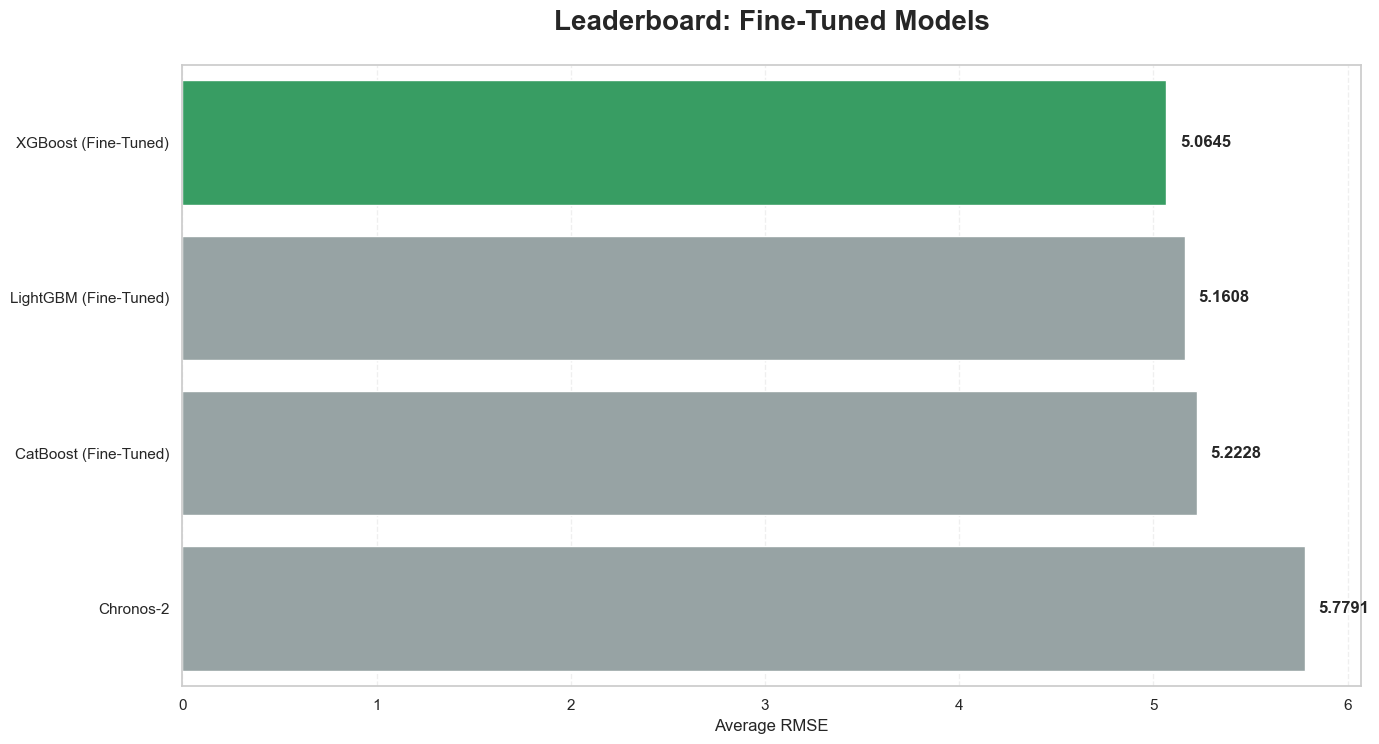

In [26]:
final_leaderboard_data = []

for model_name, baseline_rmse in results.items():
    if model_name in models_to_test:
        # Get all successful trials for this specific model type
        model_trials = [
            t.value for t in study.trials
            if t.state == optuna.trial.TrialState.COMPLETE
            and t.params.get('model_type') == model_name
        ]

        if model_trials:
            best_tuned_rmse = min(model_trials)
            # Add with a marker
            final_leaderboard_data.append({
                'Model': f"{model_name} (Fine-Tuned)",
                'RMSE': best_tuned_rmse,
                'Is_Tuned': True
            })
        else:
            # If for some reason no trial succeeded, keep baseline
            final_leaderboard_data.append({'Model': model_name, 'RMSE': baseline_rmse, 'Is_Tuned': False})
    else:
        # For non-tuned models (like Chronos 2)
        final_leaderboard_data.append({'Model': model_name, 'RMSE': baseline_rmse, 'Is_Tuned': False})

# Create and sort the DataFrame
df_final = pd.DataFrame(final_leaderboard_data).sort_values(by='RMSE', ascending=True)

plt.figure(figsize=(14, 8))
winner_overall = df_final.iloc[0]['Model']

colors = []
for _, row in df_final.iterrows():
    if row['Model'] == winner_overall:
        colors.append('#27ae60')
    else:
        colors.append('#95a5a6')

ax = sns.barplot(
    data=df_final,
    x='RMSE',
    y='Model',
    palette=colors,
    hue='Model',
    legend=False
)

# Add data labels
for i in ax.containers:
    ax.bar_label(i, fmt='%.4f', padding=10, fontsize=12, fontweight='bold')

plt.title('Leaderboard: Fine-Tuned Models', fontsize=20, fontweight='bold', pad=25)
plt.xlabel('Average RMSE', fontsize=12)
plt.ylabel('', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('images/model_leaderboard_fine_tuned.png')
plt.show()

In [27]:
# Extract best values
best_params = study.best_params.copy()
best_ntree = study.best_trial.user_attrs["best_ntree"]

fine_tuned_winner = best_params.pop('model_type')
print(f"Best Model Type: {fine_tuned_winner}")

# Handle parameter name mapping (L2 Regularization)
l2_val = best_params.pop('l2_reg', None)

if fine_tuned_winner == 'XGBoost':
    if l2_val is not None: best_params['reg_lambda'] = l2_val
    final_model = xgb.XGBRegressor(
        **best_params,
        n_estimators=best_ntree,
        tree_method='hist',
        enable_categorical=True,
        random_state=42
    )

elif fine_tuned_winner == 'CatBoost':
    if l2_val is not None: best_params['l2_leaf_reg'] = l2_val
    final_model = CatBoostRegressor(
        **best_params,
        iterations=best_ntree,
        random_seed=42,
        verbose=False,
        cat_features=categorical_features
    )

elif fine_tuned_winner == 'LightGBM':
    if l2_val is not None: best_params['reg_lambda'] = l2_val
    final_model = lgb.LGBMRegressor(
        **best_params,
        n_estimators=best_ntree,
        random_state=42,
        verbose=-1
    )

# Final Fit
final_model.fit(X_train_full, y_train_full)

print(f"Winner: {winner_overall}")
print(f"Best iteration count: {best_ntree}")

Best Model Type: XGBoost
Winner: XGBoost (Fine-Tuned)
Best iteration count: 273


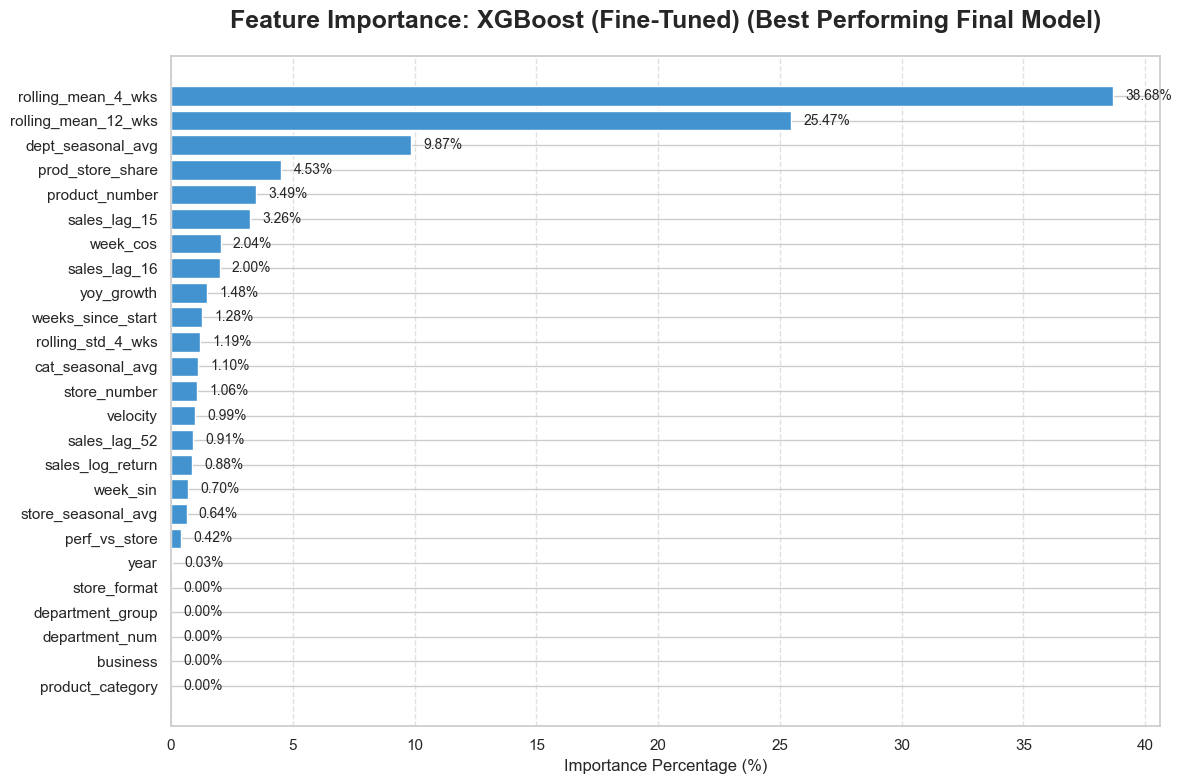

In [28]:
feature_names = X_train_full.columns

if fine_tuned_winner == 'CatBoost':
    importances = final_model.get_feature_importance()
    color = '#27ae60'
elif fine_tuned_winner == 'XGBoost':
    importances = final_model.feature_importances_
    color = '#2980b9'
elif fine_tuned_winner == 'LightGBM':
    importances = final_model.feature_importances_
    color = '#f39c12'

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Normalize importances of the features
importance_df['Importance'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100
importance_df = importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color="#4293D0")

plt.title(f'Feature Importance: {winner_overall} (Best Performing Final Model)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Importance Percentage (%)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

for index, value in enumerate(importance_df['Importance']):
    plt.text(value + 0.5, index, f'{value:.2f}%', va='center', fontsize=10)

plt.tight_layout()
save_path = f"images/feature_importance_{winner_overall}.png"
plt.savefig(save_path)
plt.show()

## Test Data

In [29]:
# Prepare the test data
X_test_engineered = data_loader.prepare_test_features(df["train"], df["test"])

# Align the columns with the training data
feature_cols = X_train_full.columns.tolist()
X_test_predict = X_test_engineered[feature_cols].copy()

# Align Categorical Dtypes
if winner_overall != 'CatBoost':
    for col in categorical_features:
        # 1. Ensure the column exists in test
        if col in X_test_predict.columns:
            # 2. Force the test column to match the training column's category dtype exactly
            X_test_predict[col] = X_test_predict[col].astype(X_train_full[col].dtype)

            # 3. Handle any potential "unseen" categories in the test set by setting them to NaN
            # (XGBoost handles NaNs in categories automatically)
            X_test_predict[col] = X_test_predict[col].where(
                X_test_predict[col].isin(X_train_full[col].cat.categories)
            )

# Verify no column-order mismatch (XGBoost requires columns in same order as training)
X_test_predict = X_test_predict[X_train_full.columns]

# Generate Final Predictions
test_predictions = final_model.predict(X_test_predict)

# Post-Processing
test_predictions = np.maximum(test_predictions, 0)

df_results = X_test_engineered[['store_number', 'product_number', 'week']].copy()
df_results['sales'] = test_predictions

df_results_preprocessed = data_loader.preprocessing(df_results)

output_path = f'results/final_sales_predictions_{winner_overall}.xlsx'
df_results.to_excel(output_path, index=False)

print(f"Predictions saved to {output_path}")
print(df_results.head())

Predictions saved to results/final_sales_predictions_XGBoost (Fine-Tuned).xlsx
     store_number  product_number       week     sales
142             0             126 2024-12-30  2.403010
143             0             126 2025-01-06  1.259533
144             0             126 2025-01-13  1.613766
145             0             126 2025-01-20  1.720457
146             0             126 2025-01-27  2.283059


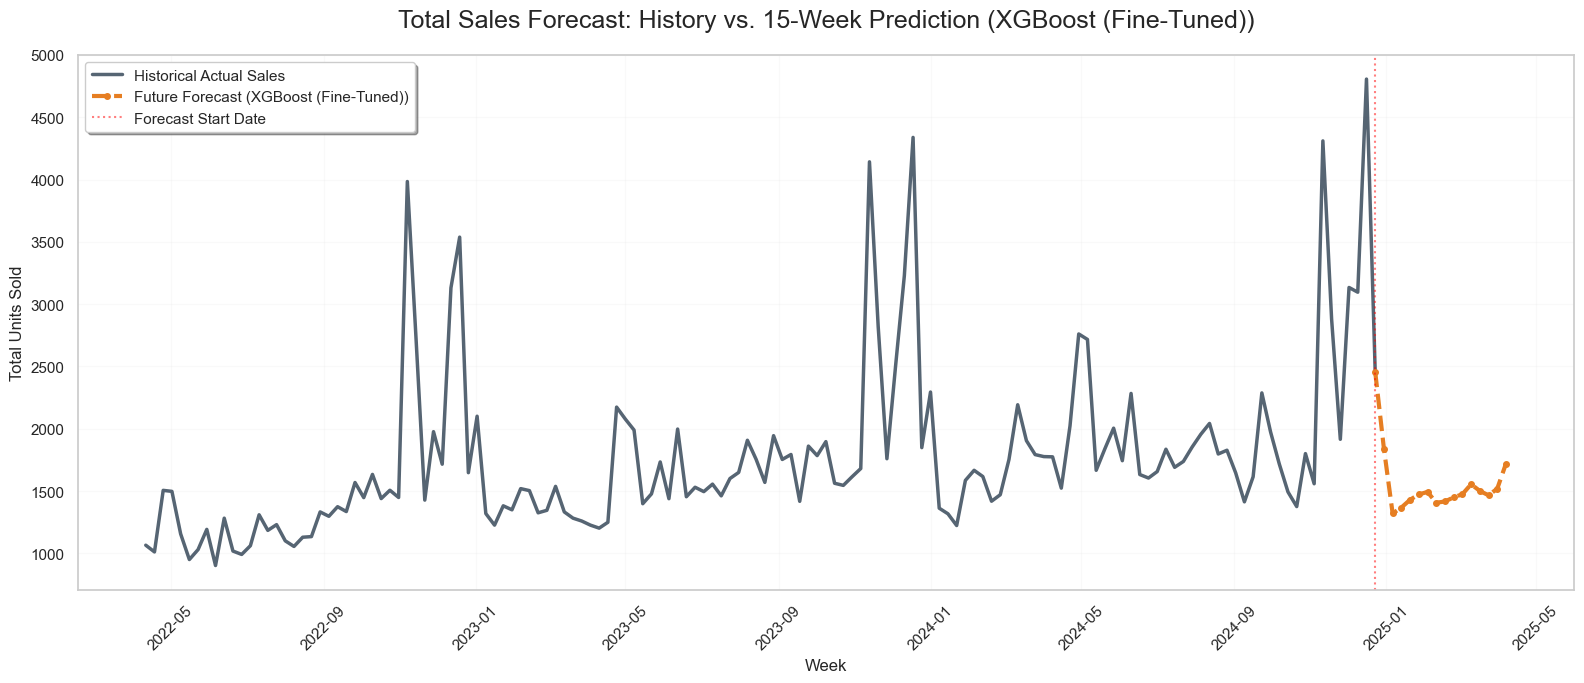

In [30]:
# Prepare Historical Data
history_weeks = data_loader.preprocessing(df['train'])['week']
df_history = pd.DataFrame({
    'week': history_weeks.loc[X_train_full.index],
    'sales': y_train_full
})
weekly_actuals = df_history.groupby('week')['sales'].sum().reset_index().sort_values('week')

weekly_forecast = df_results.groupby('week')['sales'].sum().reset_index().sort_values('week')

# Get the very last point of history
last_actual_point = weekly_actuals.tail(1).rename(columns={'sales': 'sales'})

# Attach it to the start of the forecast
weekly_forecast_connected = pd.concat([last_actual_point, weekly_forecast], ignore_index=True)

plt.figure(figsize=(16, 7))

# Plot Historical Sales
plt.plot(weekly_actuals['week'], weekly_actuals['sales'],
         label='Historical Actual Sales', color='#2c3e50', linewidth=2.5, alpha=0.8)

# Plot the Future
plt.plot(weekly_forecast_connected['week'], weekly_forecast_connected['sales'],
         label=f'Future Forecast ({winner_overall})', color='#e67e22',
         linestyle='--', linewidth=3, marker='o', markersize=4)

# Split Line
today = weekly_actuals['week'].max()
plt.axvline(x=today, color='red', linestyle=':', alpha=0.5, label='Forecast Start Date')

# Chart Styling
plt.title(f"Total Sales Forecast: History vs. 15-Week Prediction ({winner_overall})", fontsize=18, pad=20)
plt.xlabel("Week", fontsize=12)
plt.ylabel("Total Units Sold", fontsize=12)
plt.legend(loc='upper left', frameon=True, shadow=True)
plt.grid(True, which='major', linestyle='-', alpha=0.1)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('images/sales_forecast_connected.png')
plt.show()

## Trends in Forecast Data

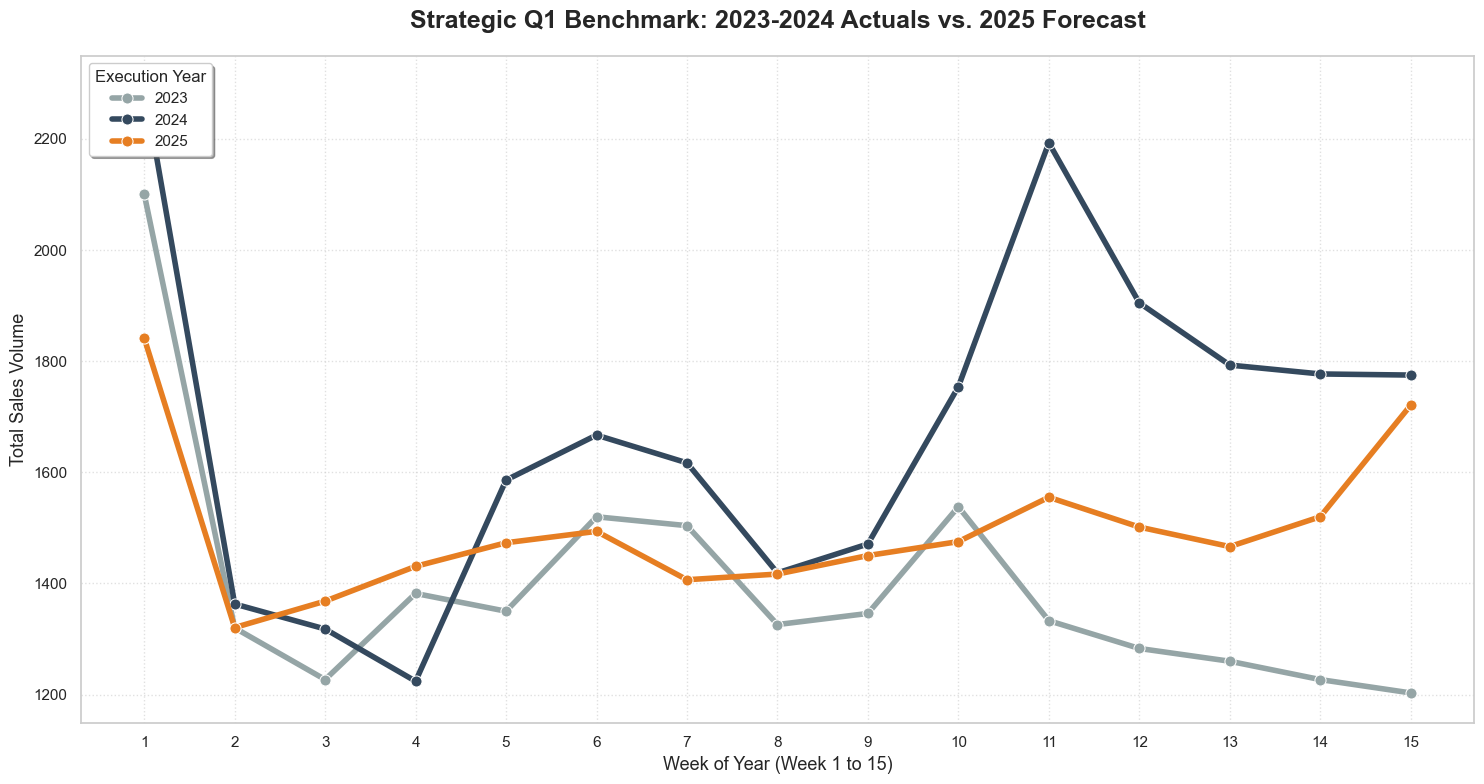

In [31]:
# Historical Data
history = X_train_preprocessed[X_train_preprocessed['year'].isin([2023, 2024])].copy()
history['week_num'] = history['week_of_year']

# Group historical sales
history_q1 = history[history['week_num'] <= 15].groupby(['year', 'week_num'])['sales'].sum().reset_index()

# Prepare Forecast Data
forecast = df_results_preprocessed.copy()
forecast['week_num'] = forecast['week_of_year']

# Group forecast sales
forecast_q1 = forecast.groupby(['year', 'week_num'])['sales'].sum().reset_index()
forecast_q1.columns = ['year', 'week_num', 'sales']

# Combine Actuals and Forecast
comparison_df = pd.concat([history_q1, forecast_q1])

plt.figure(figsize=(15, 8))

# Define a clear color palette: 2023 (Light), 2024 (Dark), 2025 (Highlight)
custom_palette = {2023: '#95a5a6', 2024: '#34495e', 2025: '#e67e22'}

sns.lineplot(
    data=comparison_df,
    x='week_num',
    y='sales',
    hue='year',
    palette=custom_palette,
    linewidth=4,
    marker='o',
    markersize=8
)

# Chart Styling
plt.title('Strategic Q1 Benchmark: 2023-2024 Actuals vs. 2025 Forecast', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Week of Year (Week 1 to 15)', fontsize=13)
plt.ylabel('Total Sales Volume', fontsize=13)
plt.xticks(range(1, 16))
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(title="Execution Year", loc='upper left', frameon=True, shadow=True)

plt.tight_layout()
plt.savefig("images/benchmark_yoy.png")
plt.show()

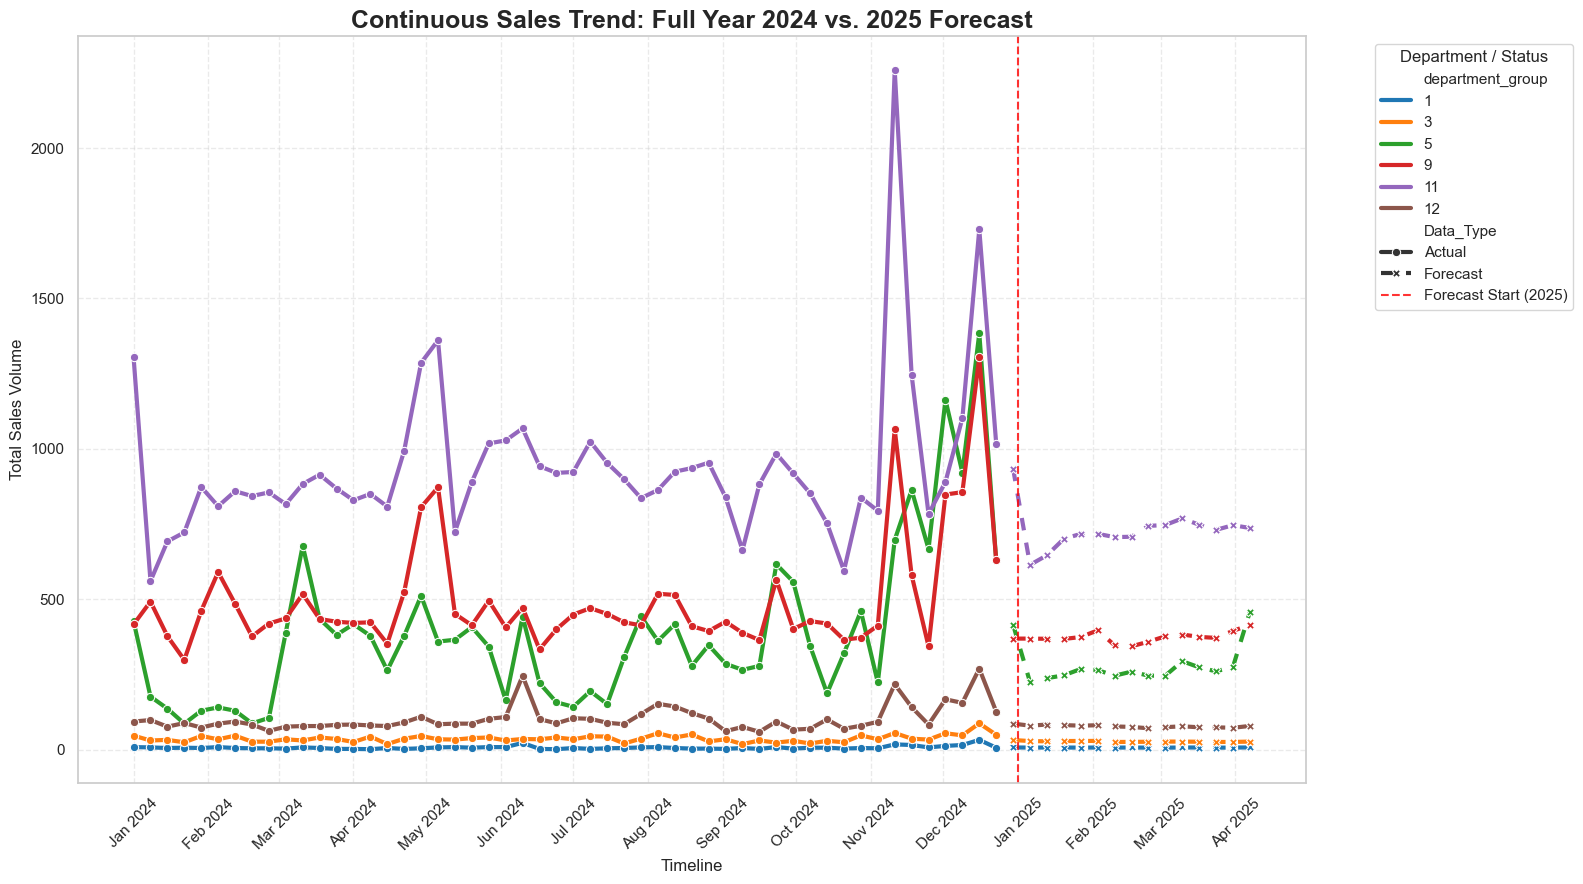

In [32]:
target_col = data_loader.get_target_col()
date_col = data_loader.get_date_col()

history_df = X_train_engineered.copy()

# Filter for the year 2024 to keep the transition clear
history_2024 = history_df[history_df[date_col].dt.year == 2024].copy()

# Group by date and department to get the total volume per week
seasonal_sum = history_2024.groupby([date_col, 'department_group'])[target_col].sum().reset_index()
seasonal_sum['Data_Type'] = 'Actual'

# Create a copy of the test features and add final predictions
X_test_plot = X_test_engineered.copy()
X_test_plot[target_col] = test_predictions

# Group by date and department
forecast_sum = X_test_plot.groupby([date_col, 'department_group'])[target_col].sum().reset_index()
forecast_sum['Data_Type'] = 'Forecast'

combined_plot_data = pd.concat([seasonal_sum, forecast_sum], axis=0).sort_values(by=date_col)

plt.figure(figsize=(16, 9))

# Lineplot with different styles for Actual vs Forecast
sns.lineplot(
    data=combined_plot_data,
    x=date_col,
    y=target_col,
    hue='department_group',
    style='Data_Type',
    markers=True,
    dashes={'Actual': '', 'Forecast': (3, 3)},
    linewidth=3,
    palette="tab10"
)

# Add a vertical line for the New Year transition
plt.axvline(pd.Timestamp('2025-01-01'), color='red', linestyle='--', alpha=0.8, label='Forecast Start (2025)')

# Formatting
plt.title('Continuous Sales Trend: Full Year 2024 vs. 2025 Forecast', fontsize=18, fontweight='bold')
plt.ylabel('Total Sales Volume', fontsize=12)
plt.xlabel('Timeline', fontsize=12)

# Format the X-axis to show Month and Year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(title='Department / Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("images/sales_trend_per_department.png")
plt.show()